# Embedding Representations

## Load data

In [1]:
import numpy as np

def load_embeddings(filename):
    fin = open(filename, 'r')
    node_num, size = [int(x) for x in fin.readline().strip().split()]
    vectors = {}
    while 1:
        l = fin.readline()
        if l == '':
            break
        vec = l.strip().split(' ')
        assert len(vec) == size+1
        vectors[vec[0]] = [float(x) for x in vec[1:]]
    fin.close()
    assert len(vectors) == node_num
    return vectors

def load_node_label(filename):
    fin = open(filename, 'r')
    X = []
    Y = []
    while 1:
        l = fin.readline()
        if l == '':
            break
        vec = l.strip().split(' ')
        X.append(vec[0])
        labels = vec[1:]
        if len(labels)==1:
            Y.append(int(labels[0]))
        else:
            Y.append(-1)
    fin.close()
    return X, Y

def load_dataset(emb_filename, label_filename):
    emb_dict = load_embeddings(emb_filename)
    X, Y = load_node_label(label_filename)
    lbl_dict = dict(zip(X,Y))
    nodes = sorted(emb_dict.keys())
    lbl = np.array([lbl_dict[node] for node in nodes])
    emb = np.array([emb_dict[node] for node in nodes])
    return emb, lbl
    
def load_unlabeled(emb_filename):
    emb_dict = load_embeddings(emb_filename)
    nodes = sorted(emb_dict.keys())
    lbl = np.array([1 for node in nodes])
    emb = np.array([emb_dict[node] for node in nodes])
    return emb, lbl
    

## Plotting function

In [2]:
%matplotlib notebook

import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
from   sklearn.decomposition import PCA
from   sklearn.manifold import TSNE, Isomap, LocallyLinearEmbedding, MDS, SpectralEmbedding
from   sklearn.preprocessing import StandardScaler

np.set_printoptions(suppress=True)
np.set_printoptions(precision=4)
plt_style = 'seaborn-talk'

# Experimental: HDBScan is a state-of-the-art clustering algorithm
hdbscan_available = True
try:
    import hdbscan
except ImportError:
    hdbscan_available = False
    
def do_plot(X_fit, labels, title=None):
    dimension = X_fit.shape[1]
    label_types = sorted(list(set(labels).difference({-1})))
    num_labels = len(label_types)
    colors = cm.Accent(np.linspace(0, 1, num_labels))

    gray = np.array([0.7, 0.7, 0.7, 1.0]).reshape(1,4)
    label_types.insert(0,-1)
    colors = np.concatenate((gray, colors))    
    
    with plt.style.context(plt_style):
        fig = plt.figure()
        if dimension == 2:
            ax = fig.add_subplot(111)
            for lab, col in zip(label_types, colors):
                ax.scatter(X_fit[labels==lab, 0],
                           X_fit[labels==lab, 1],
                           c=col)
        elif dimension == 3:
            ax = fig.add_subplot(111, projection='3d')
            for lab, col in zip(label_types, colors):
                ax.scatter(X_fit[labels==lab, 0],
                           X_fit[labels==lab, 1],
                           X_fit[labels==lab, 2],
                           c=col)
        else:
            raise Exception('Unknown dimension: %d' % dimension)
        plt.title(title)
        plt.show()
        plt.savefig('{}.eps'.format(title))

## Generate the data
To create a simple test case, we generate some Gaussian point clouds in $\mathbb{R}^3$. Then we see how they look embedded in $\mathbb{R}^2$ and $\mathbb{R}^3$ using various algorithms, including t-SNE.

There's one point cloud centered at the origin and three on each of the three axes. They are well separated, as can be seen in the first visualization below.

In [2]:
num_dimensions = 3
num_clusters = 4
num_points = 100
cluster_separation = 6
centers = np.array([(0,0,0), (1,0,0), (0,1,0), (0,0,1)], dtype=float) * cluster_separation
data = np.zeros((num_clusters * num_points, num_dimensions), dtype=float)
labels = np.zeros(num_clusters * num_points, dtype=int)
for c in range(num_clusters):
    start = c * num_points
    end = start + num_points
    data[start:end, :] = np.random.randn(num_points, num_dimensions) + centers[c]
    labels[start:end] = c
data_df = pd.DataFrame(data, columns=('x','y','z'))
data_df['label'] = labels
data_df.head()

x         y         z  label
0 -1.554748  2.505869  1.047302      0
1  0.541263 -0.299623 -0.227858      0
2  0.292000  0.156481 -1.114547      0
3 -0.191121 -0.304512  0.555882      0
4 -0.452935  0.767427 -0.627971      0

## Prep the data for fitting and visualizing

In [24]:
X = data_df.iloc[:,0:-1]
X_std = StandardScaler().fit_transform(X)
y = data_df['label'].values



<type 'numpy.ndarray'>


## 3D view

<IPython.core.display.Javascript object>


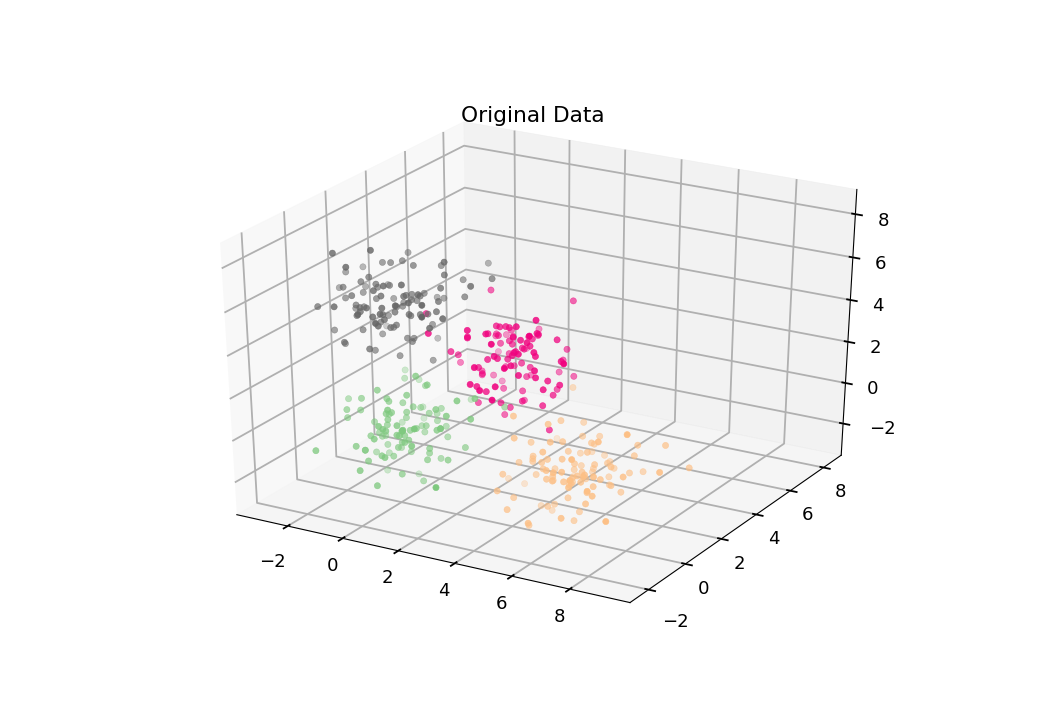

In [7]:
do_plot(X.values, y, 'Original Data')

In [8]:
X.values[:,0:-1].shape

(400, 2)

## Dumb 2D projection
The easiest way to embed our data into two dimensions is to project onto the plane $x=0$.

<IPython.core.display.Javascript object>


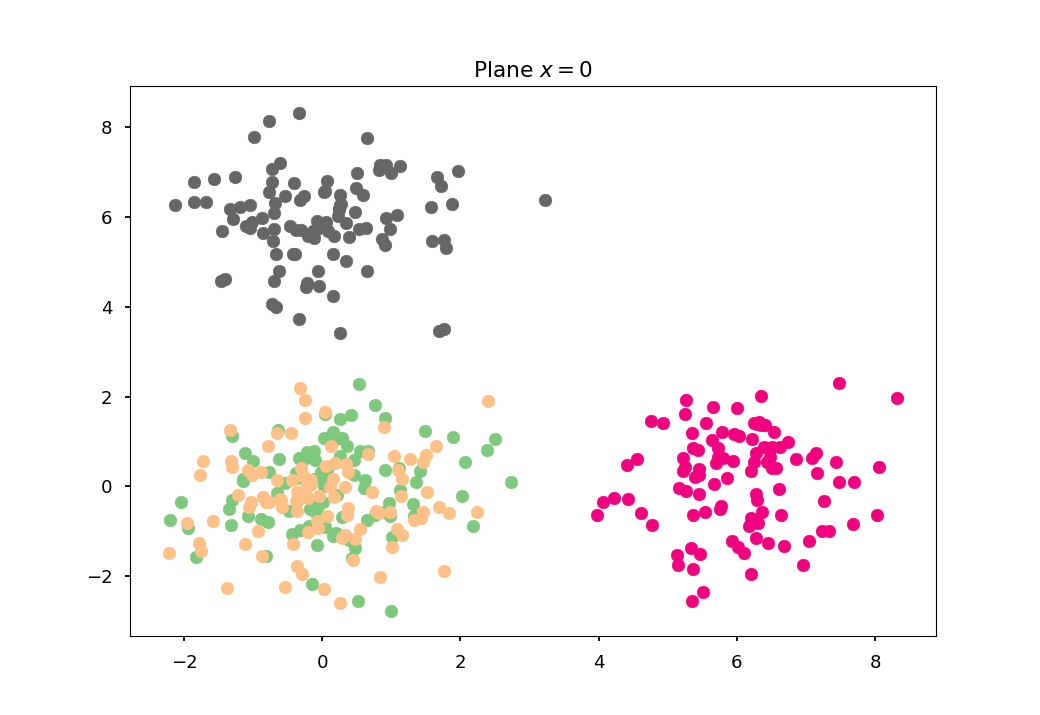

In [9]:
do_plot(X.values[:,1:], y, 'Plane $x=0$')

## PCA (2D)

<IPython.core.display.Javascript object>


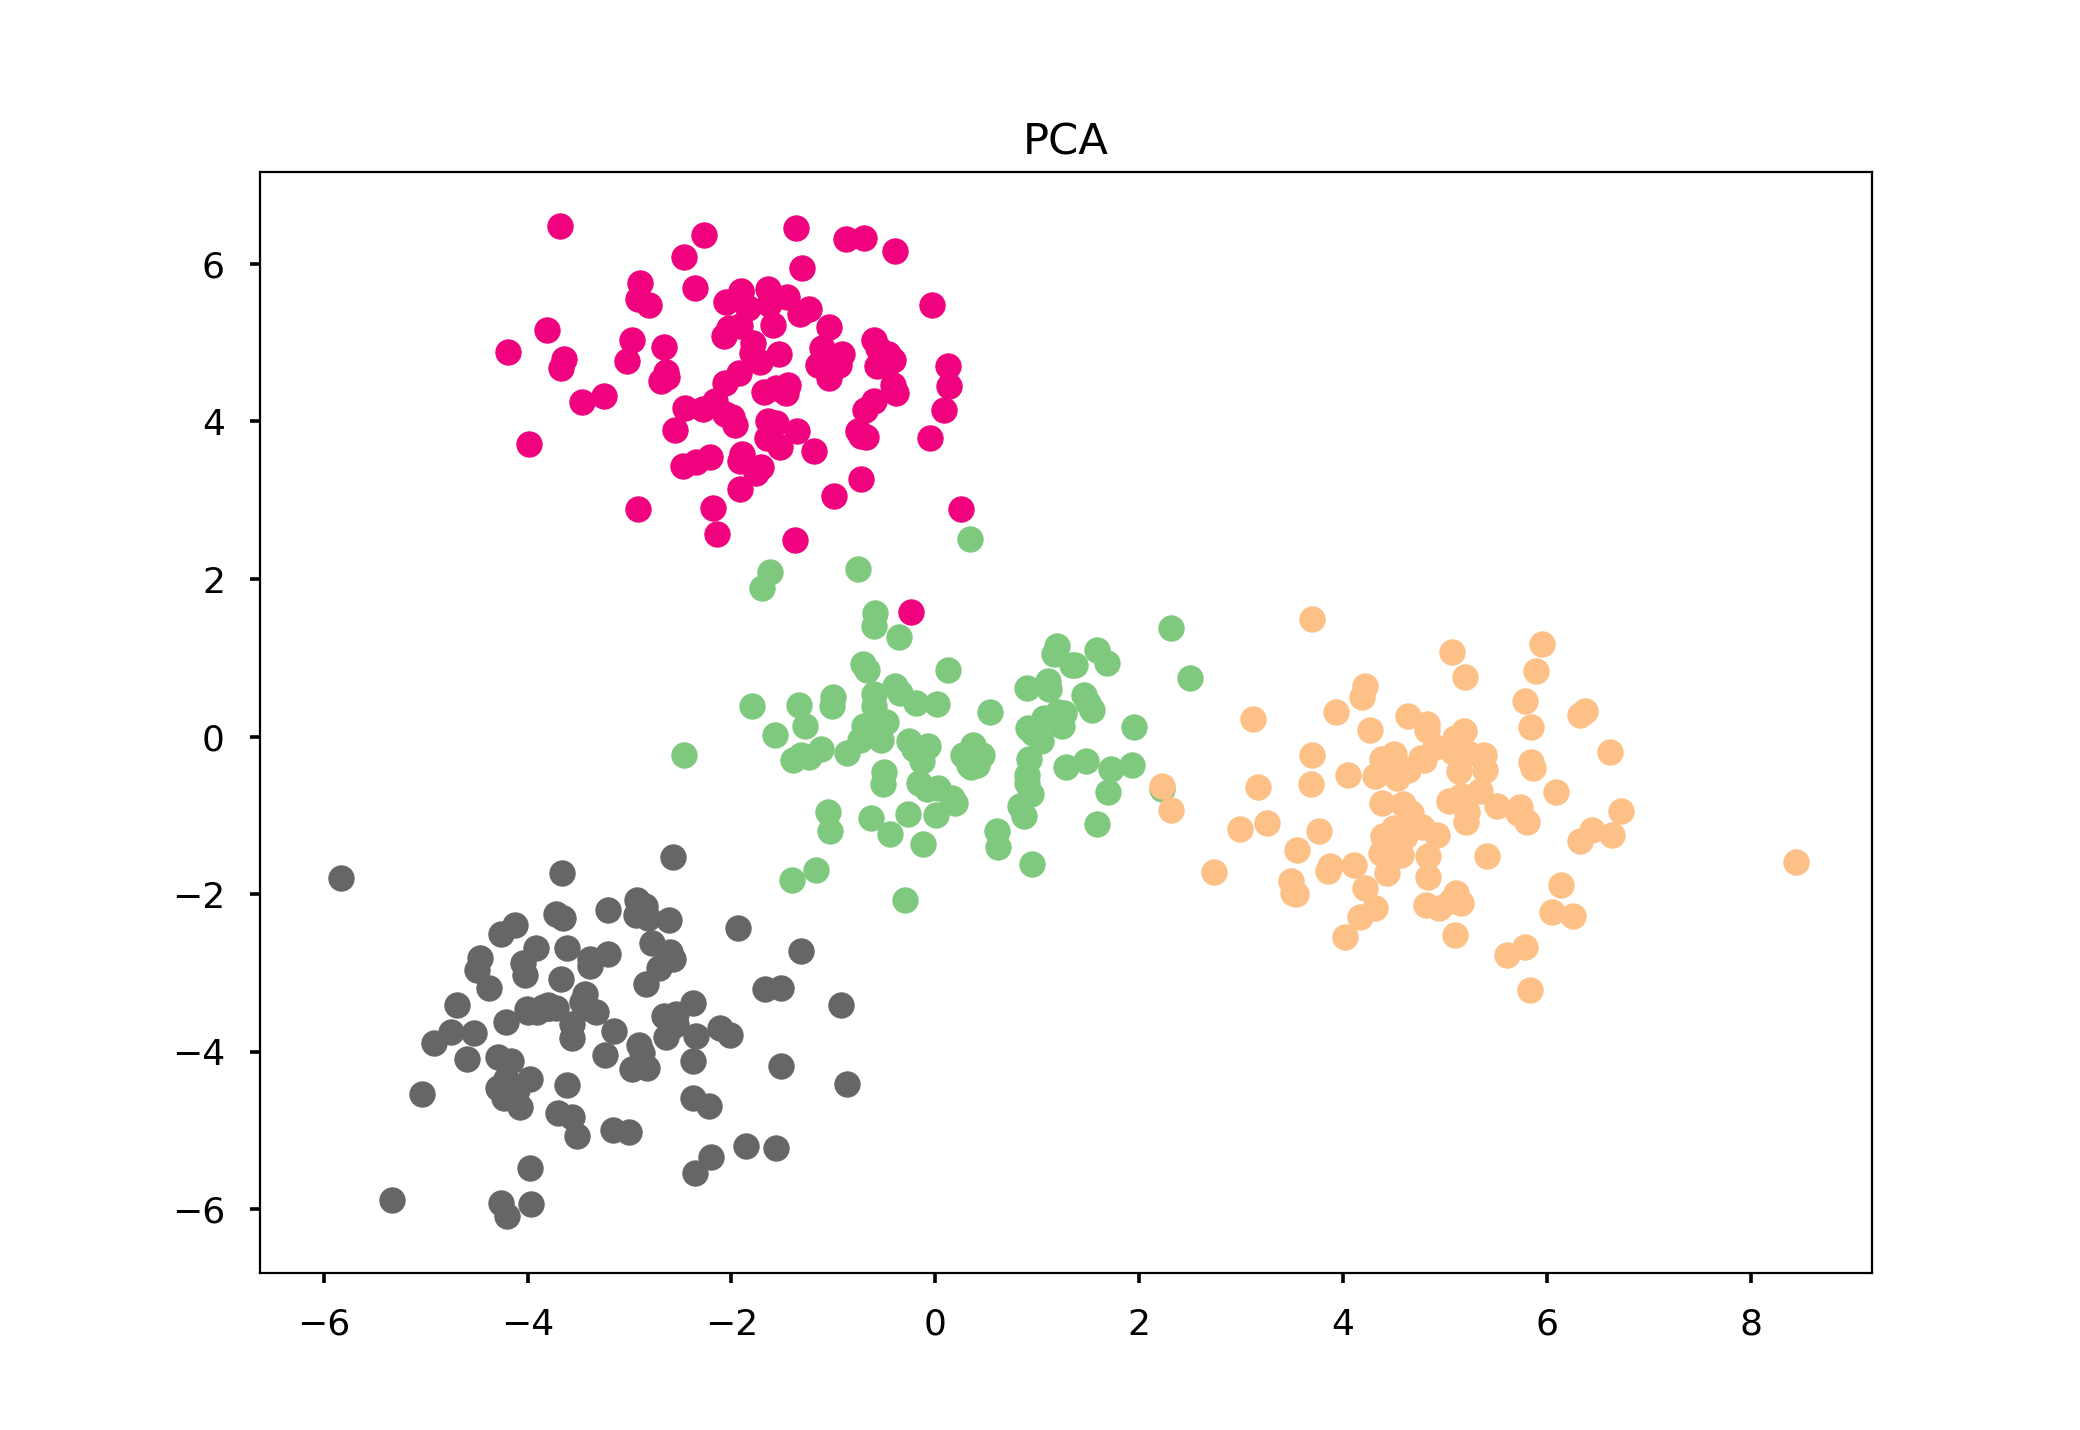

In [9]:
do_plot(PCA(n_components=2).fit_transform(X), 'PCA')

<IPython.core.display.Javascript object>


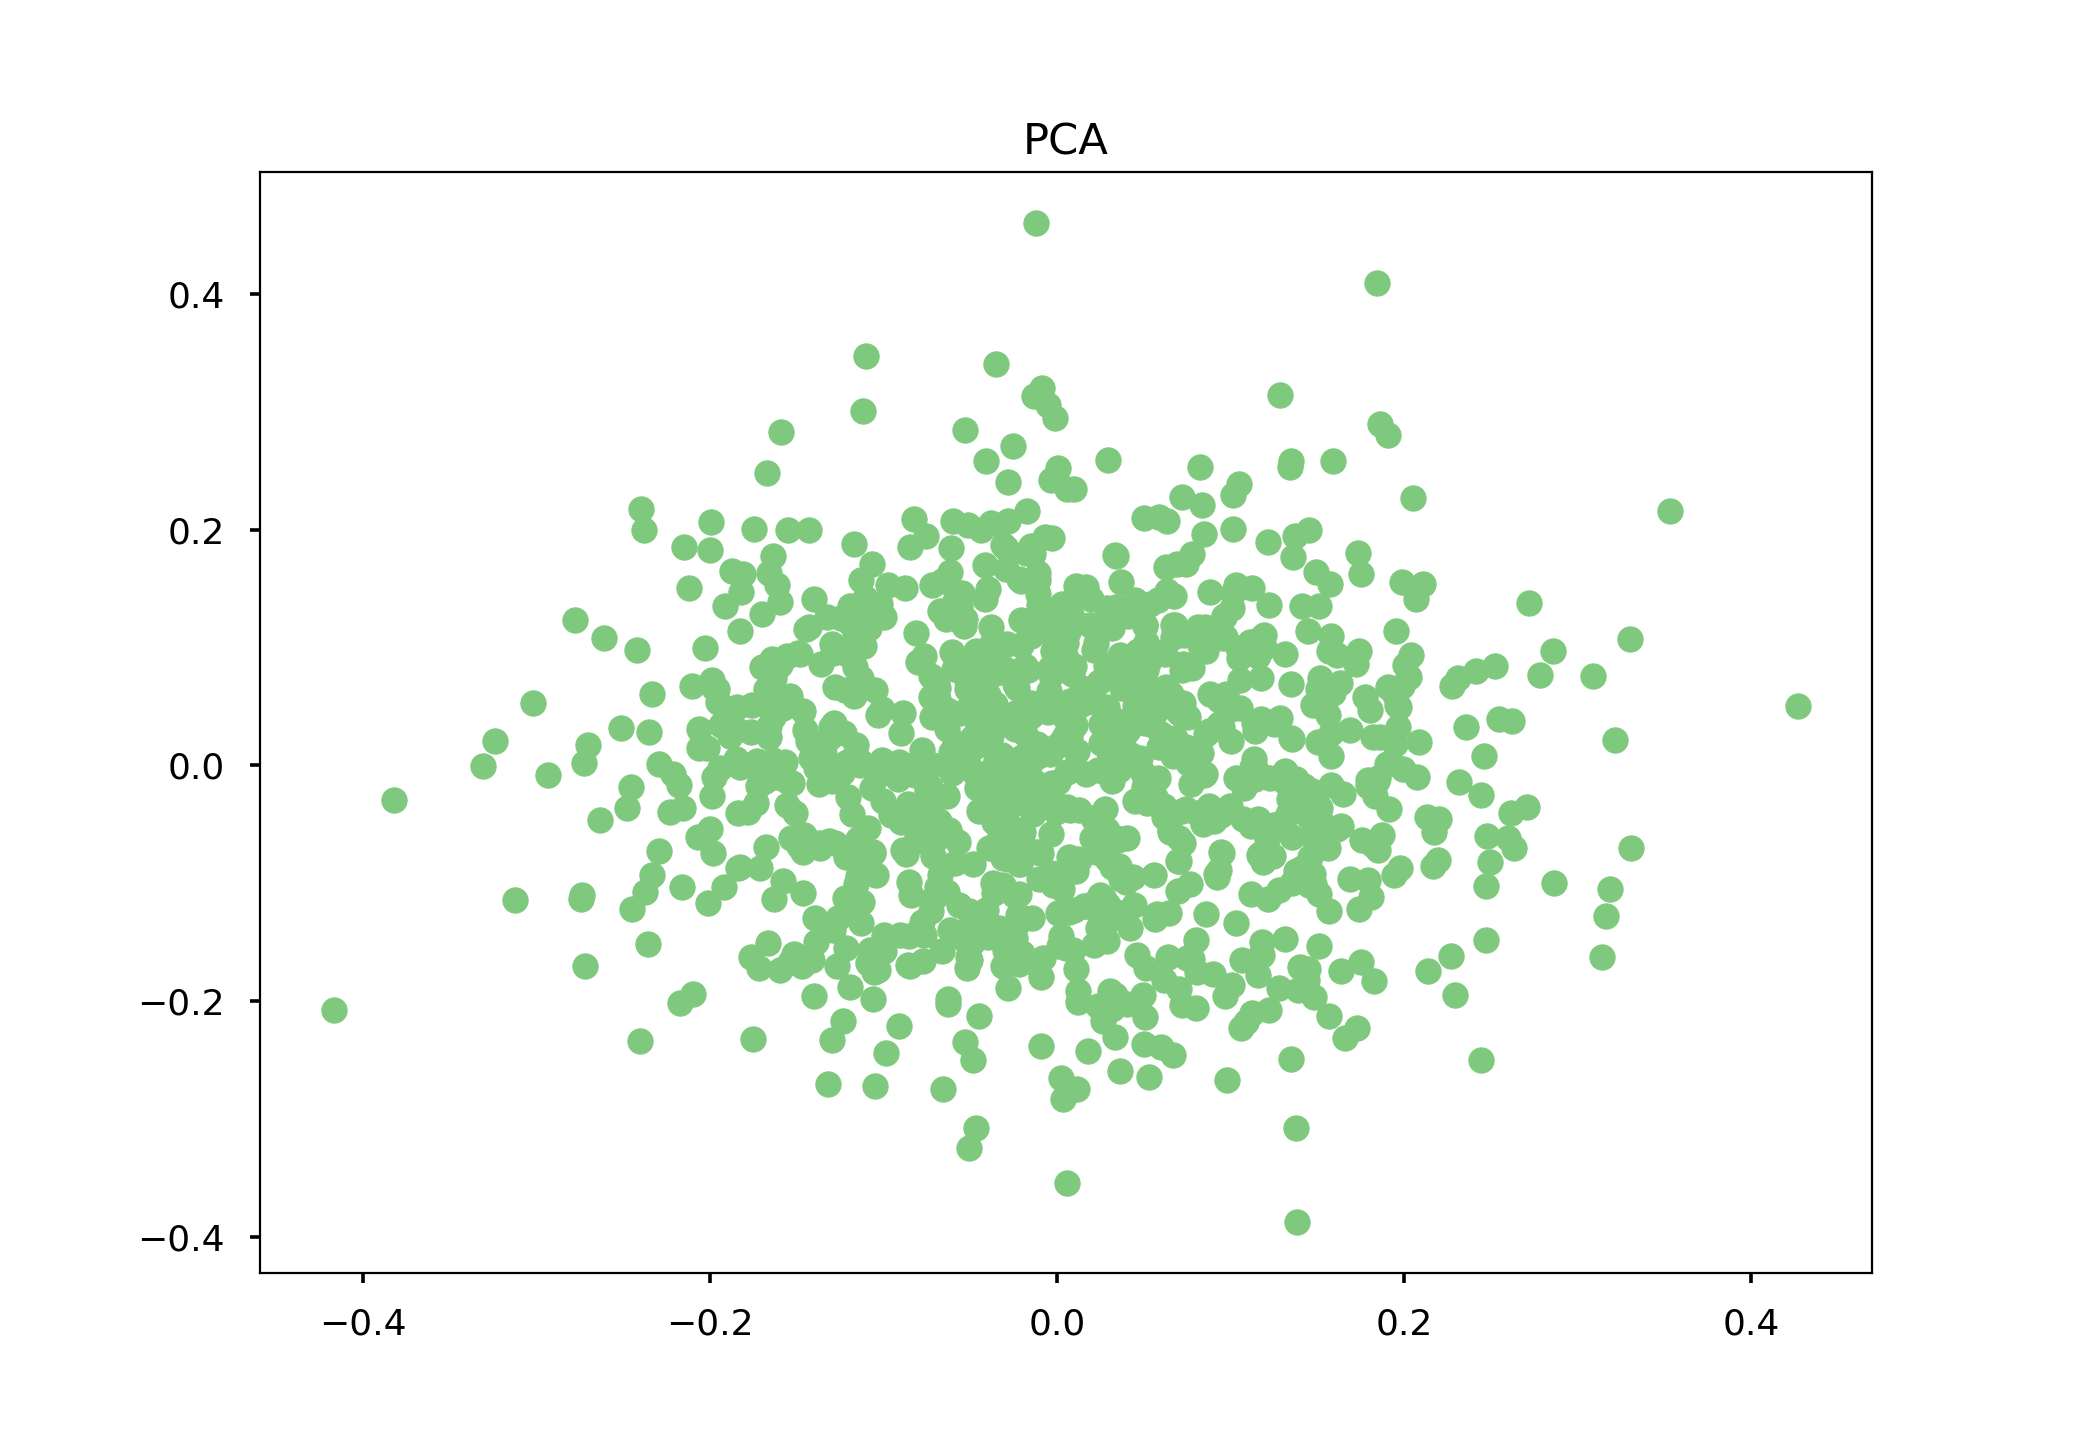

In [8]:
emb, lbl = load_unlabeled('../emb/vec_star_edge2vec.txt')
do_plot(PCA(n_components=2).fit_transform(emb), lbl, 'PCA')

<IPython.core.display.Javascript object>


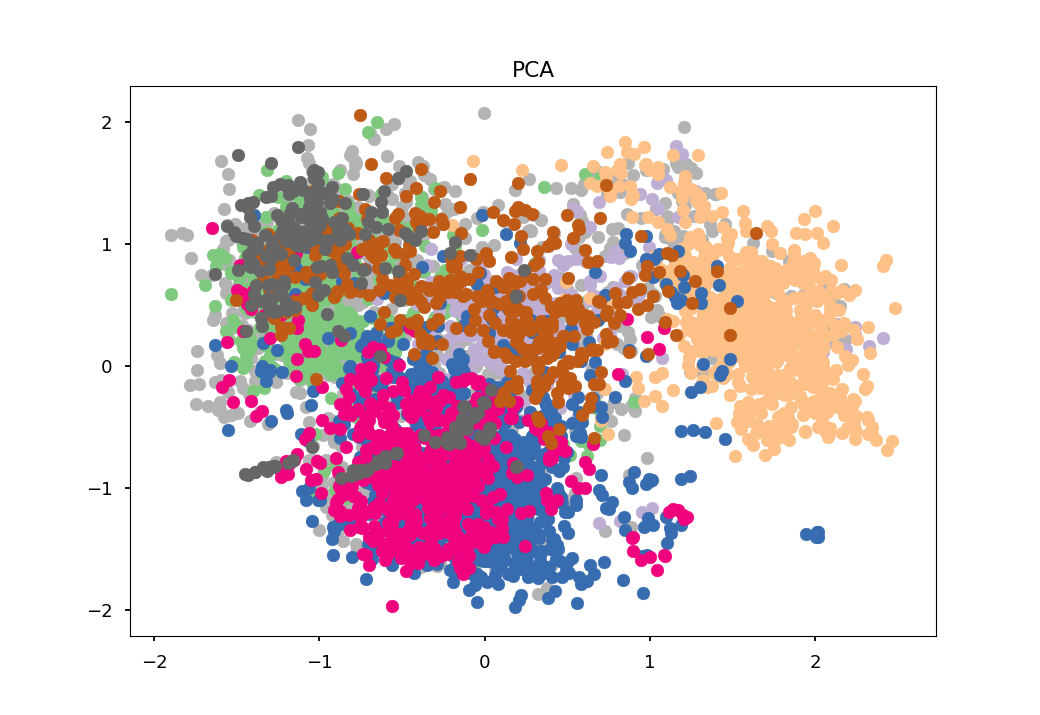

In [82]:
emb, lbl = load_dataset('../emb/vec_cora_edge2vec.txt', '../emb/label_cora_edge2vec.txt')
do_plot(PCA(n_components=2).fit_transform(emb), lbl, 'PCA')

## Isomap

<IPython.core.display.Javascript object>


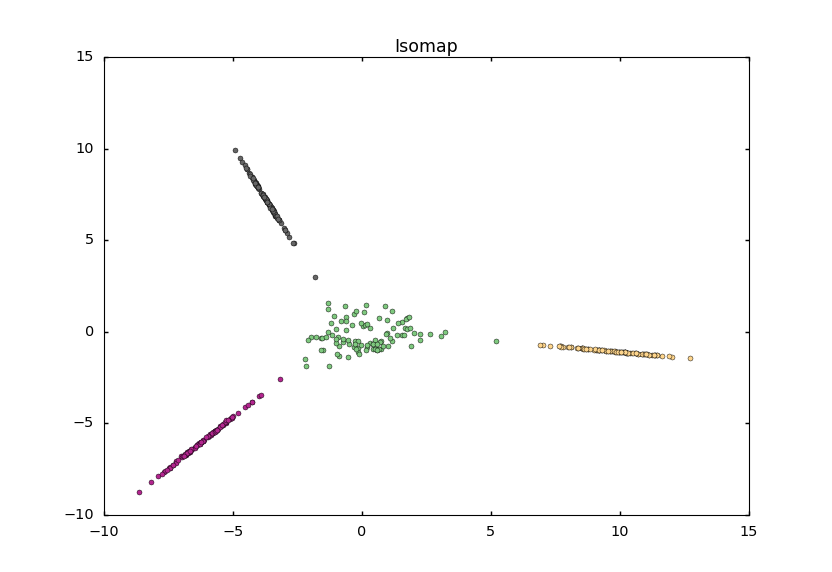

In [90]:
do_plot(Isomap(n_components=2).fit_transform(X), 'Isomap')

## Locally Linear Embedding

<IPython.core.display.Javascript object>


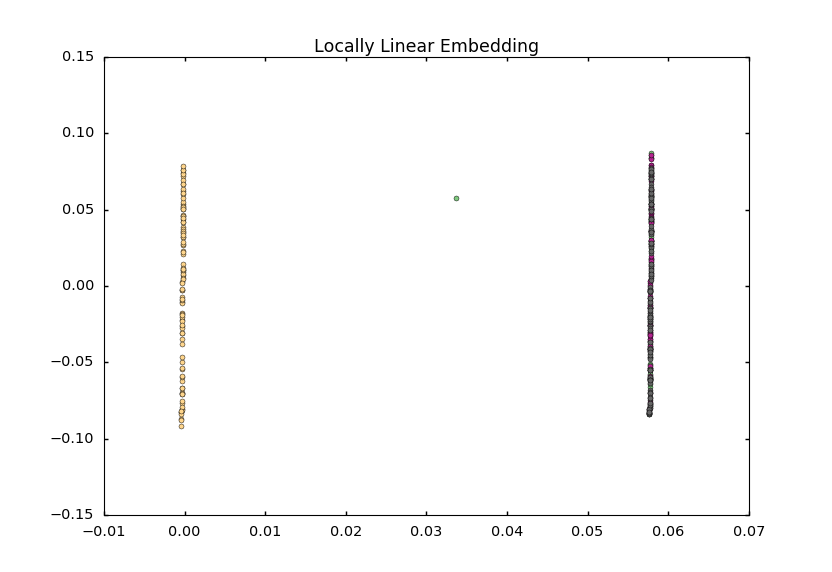

In [91]:
do_plot(LocallyLinearEmbedding(n_components=2).fit_transform(X), 'Locally Linear Embedding')

## Spectral Embedding

<IPython.core.display.Javascript object>


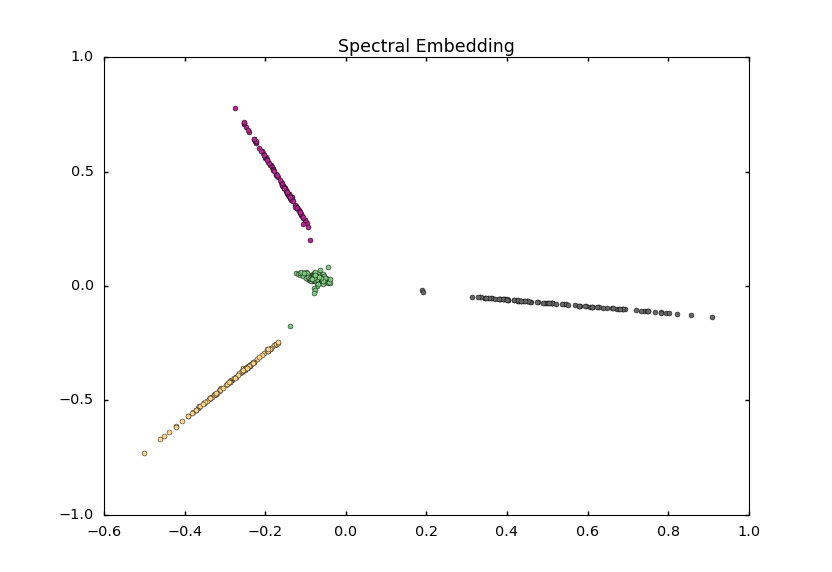

In [92]:
do_plot(SpectralEmbedding(n_components=2).fit_transform(X), 'Spectral Embedding')

## Multi-dimensional scaling (MDS)

<IPython.core.display.Javascript object>


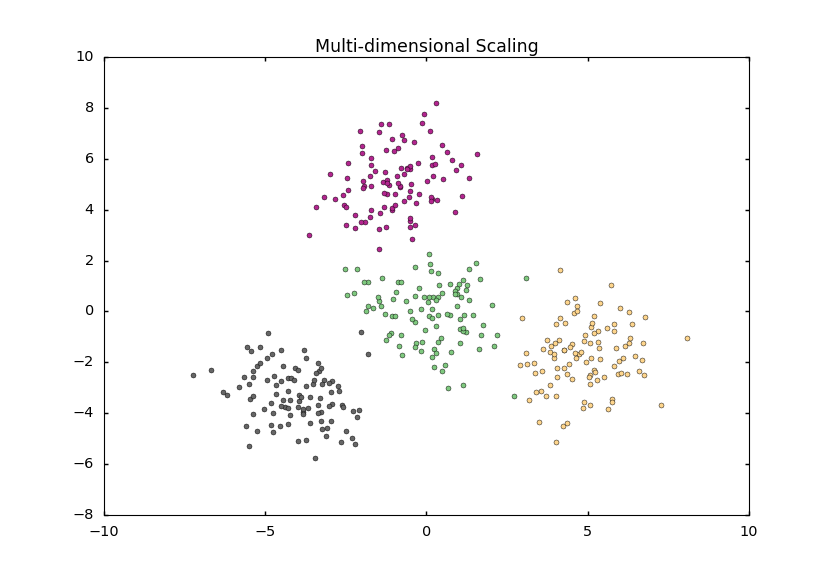

In [93]:
do_plot(MDS(n_components=2).fit_transform(X), 'Multi-dimensional Scaling')

## t-SNE (2D)

<IPython.core.display.Javascript object>


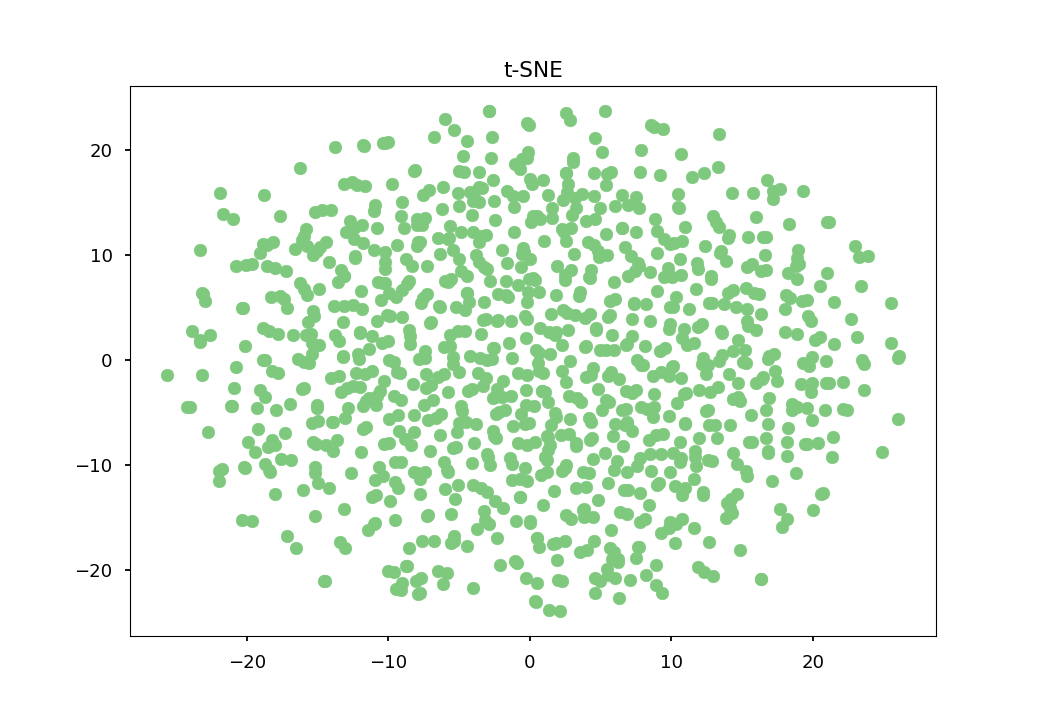

In [59]:
emb, lbl = load_dataset('../emb/vec_star_node2vec.txt')

tsne2 = TSNE(n_components=2, random_state=0)
do_plot(tsne2.fit_transform(emb), lbl, 't-SNE')

<IPython.core.display.Javascript object>


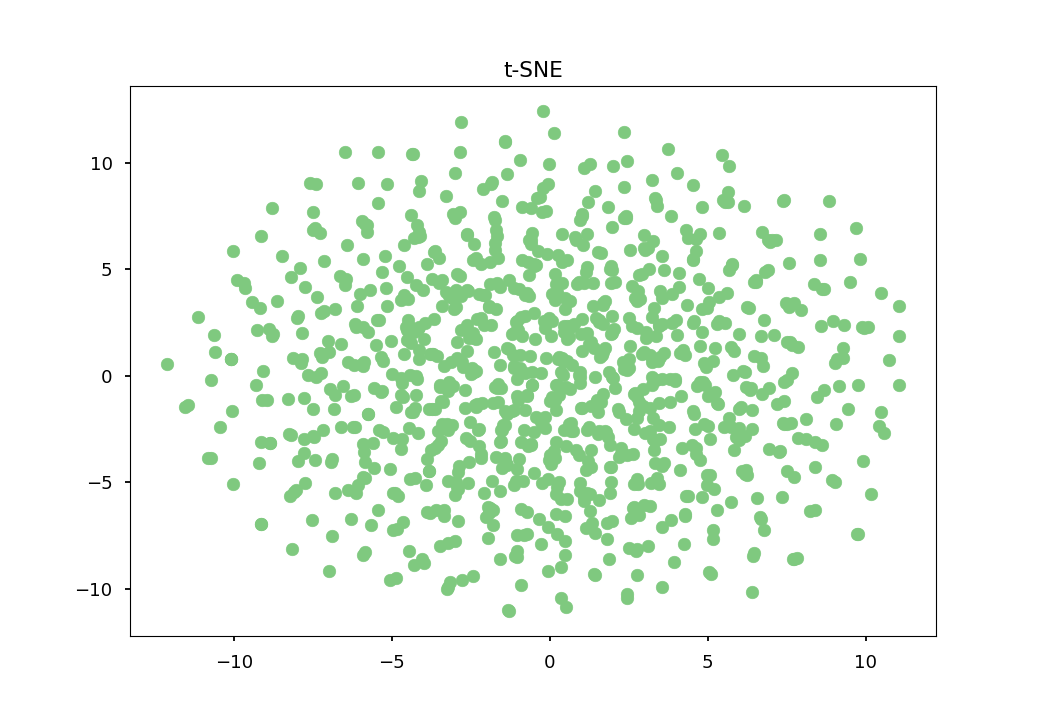

In [60]:
emb, lbl = load_dataset('../emb/vec_star_edge2vec.txt')

tsne2 = TSNE(n_components=2, random_state=0)
do_plot(tsne2.fit_transform(emb), lbl, 't-SNE')

In [3]:
databases = { 'citeseer', 'cora', 'wiki', 'ppi','facebook'} #  'pos',
methods = {'cte', 'deepWalk', 'deepWalk_line'} # 'node2vec', 'edge2vec'
embeddings = {}
labels = {}
 
for database in databases:
    for method in methods:
        key = '{}-{}'.format(database, method)
        print(key)
        emb, lbl = load_dataset('../emb/vec_{}_{}.txt'.format(database, method), '../emb/label_{}_{}.txt'.format(database, method))        
        tsne2 = TSNE(n_components=2, random_state=0)
        embeddings[key] = tsne2.fit_transform(emb)
        labels[key] = lbl
        #do_plot(embeddings[key], labels[key], 't-SNE {}'.format(key))

wiki-cte
wiki-deepWalk_line
wiki-deepWalk
facebook-cte
facebook-deepWalk_line
facebook-deepWalk
ppi-cte
ppi-deepWalk_line
ppi-deepWalk
citeseer-cte
citeseer-deepWalk_line
citeseer-deepWalk
cora-cte
cora-deepWalk_line
cora-deepWalk


<IPython.core.display.Javascript object>


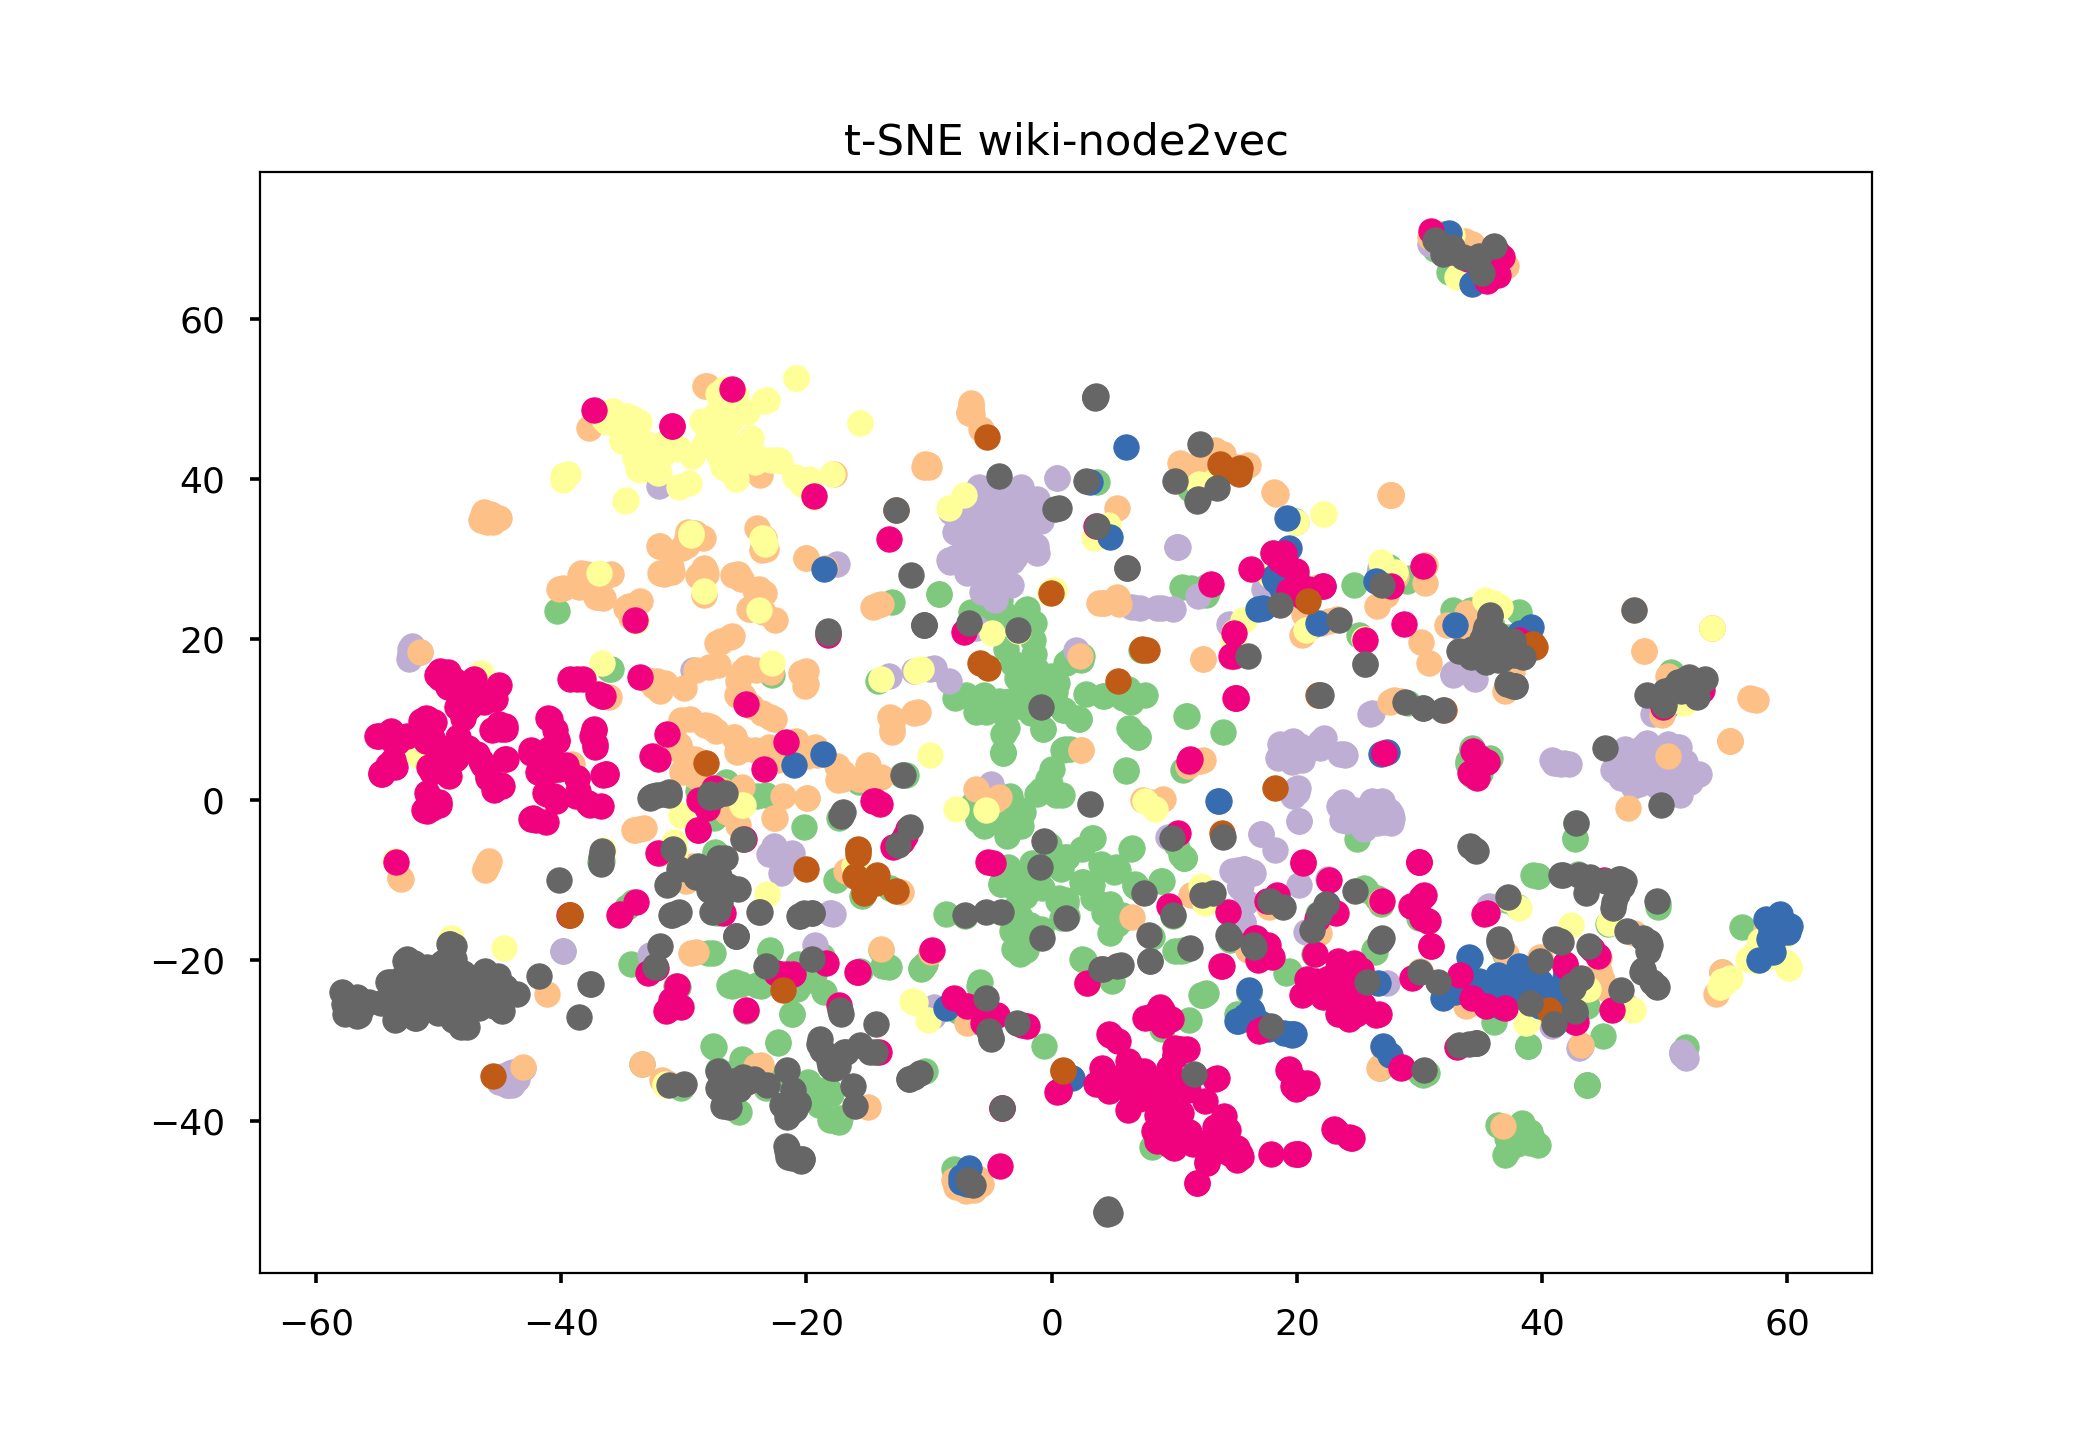

<IPython.core.display.Javascript object>


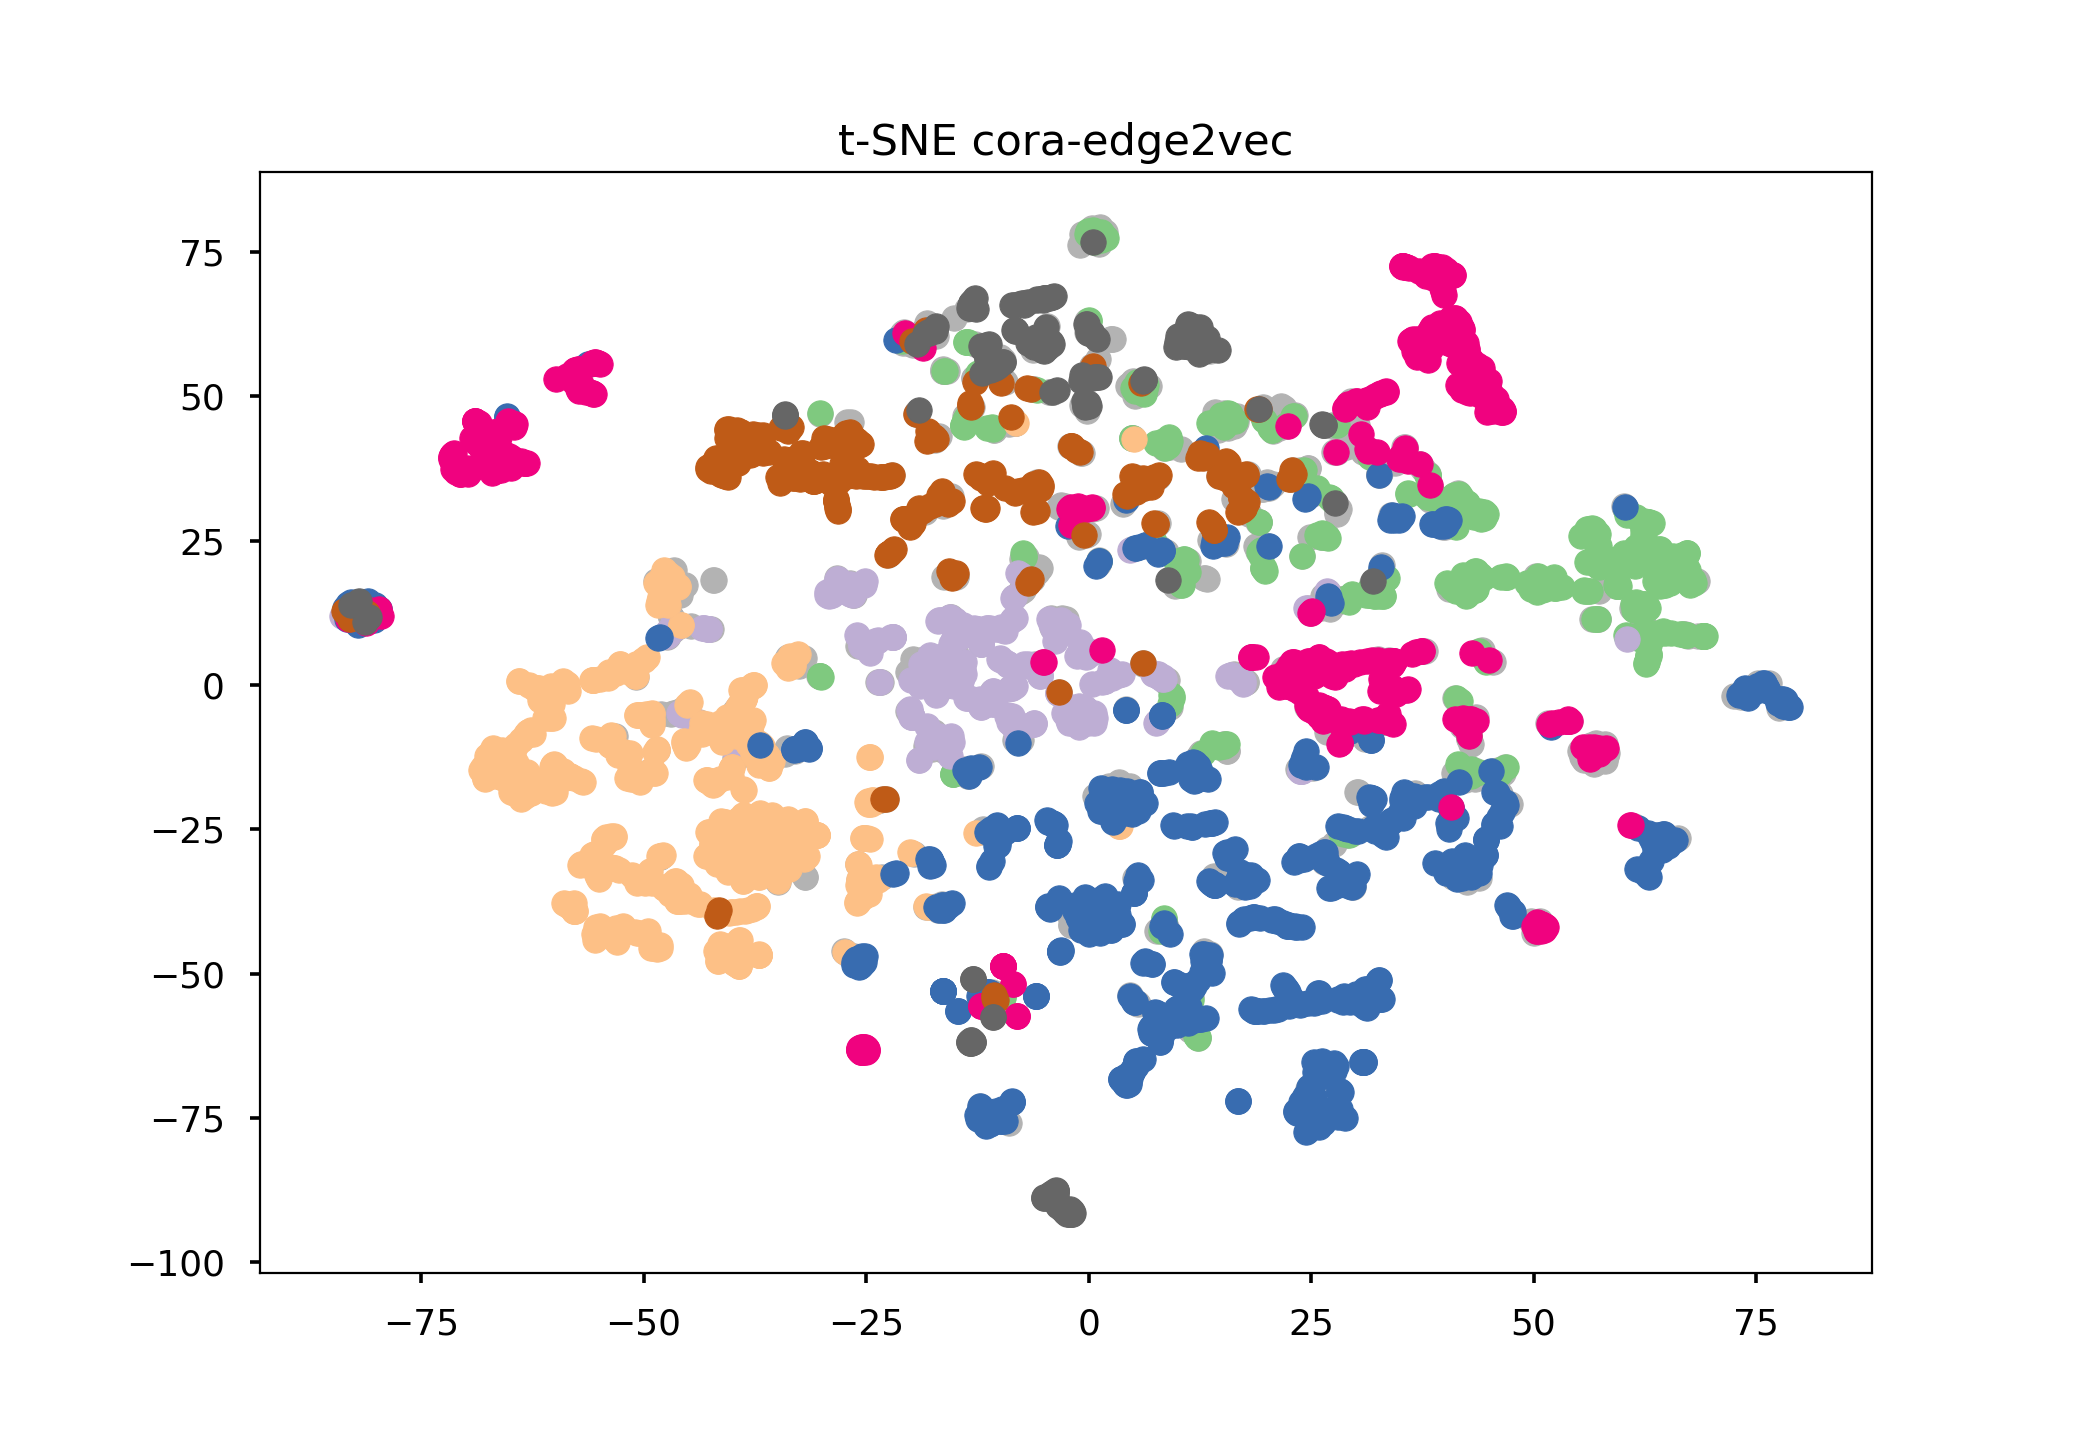

<IPython.core.display.Javascript object>


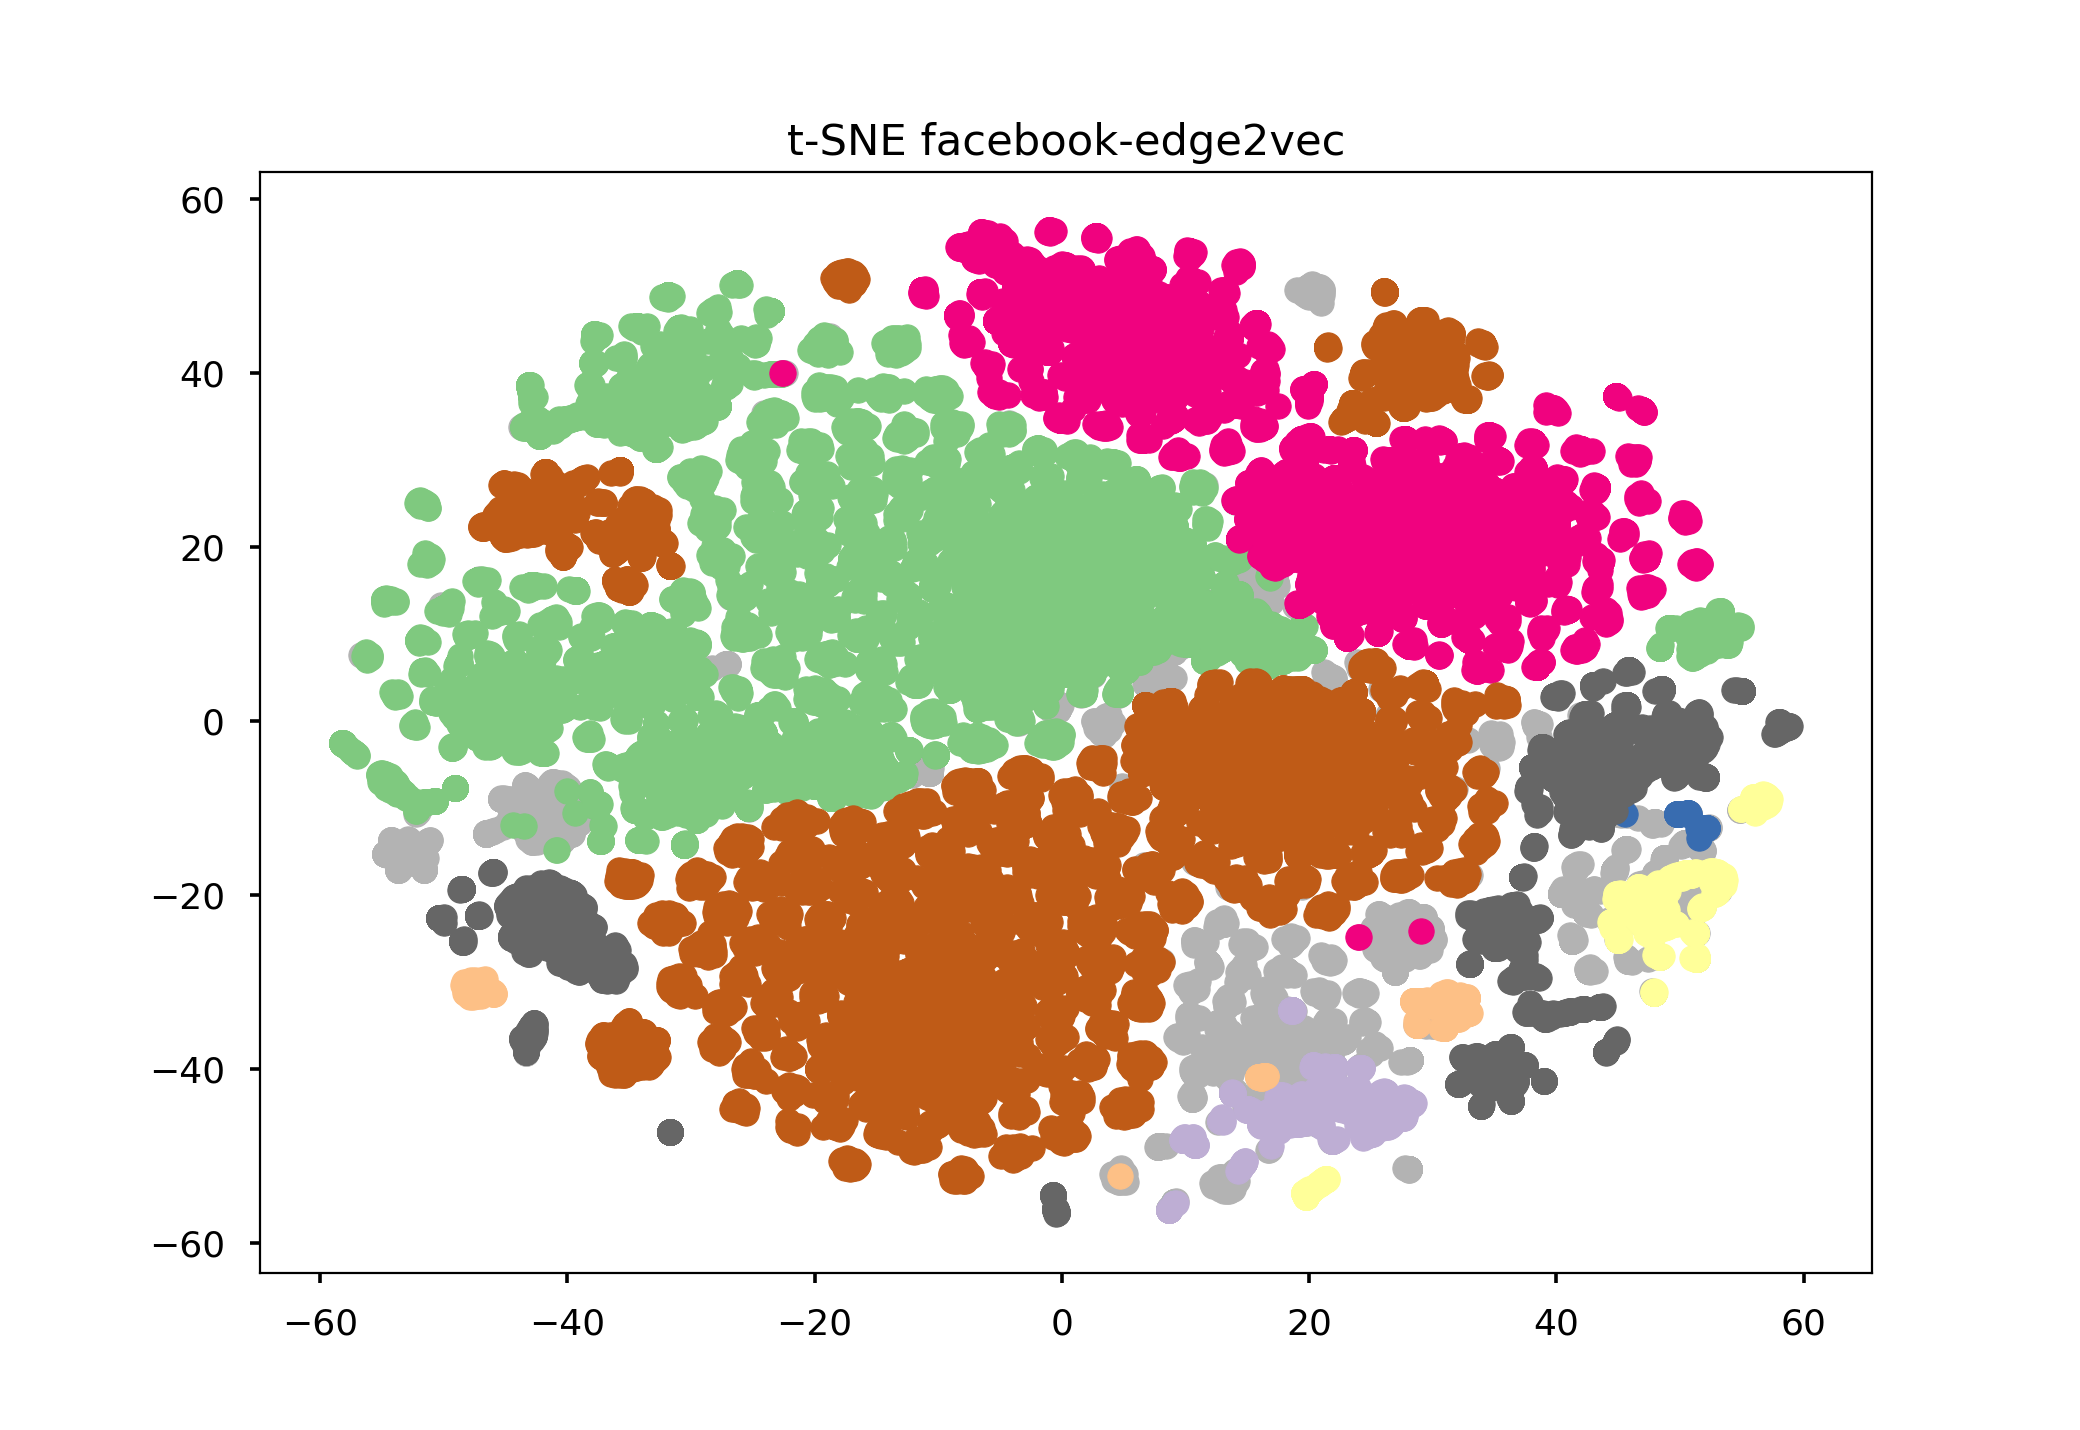

<IPython.core.display.Javascript object>


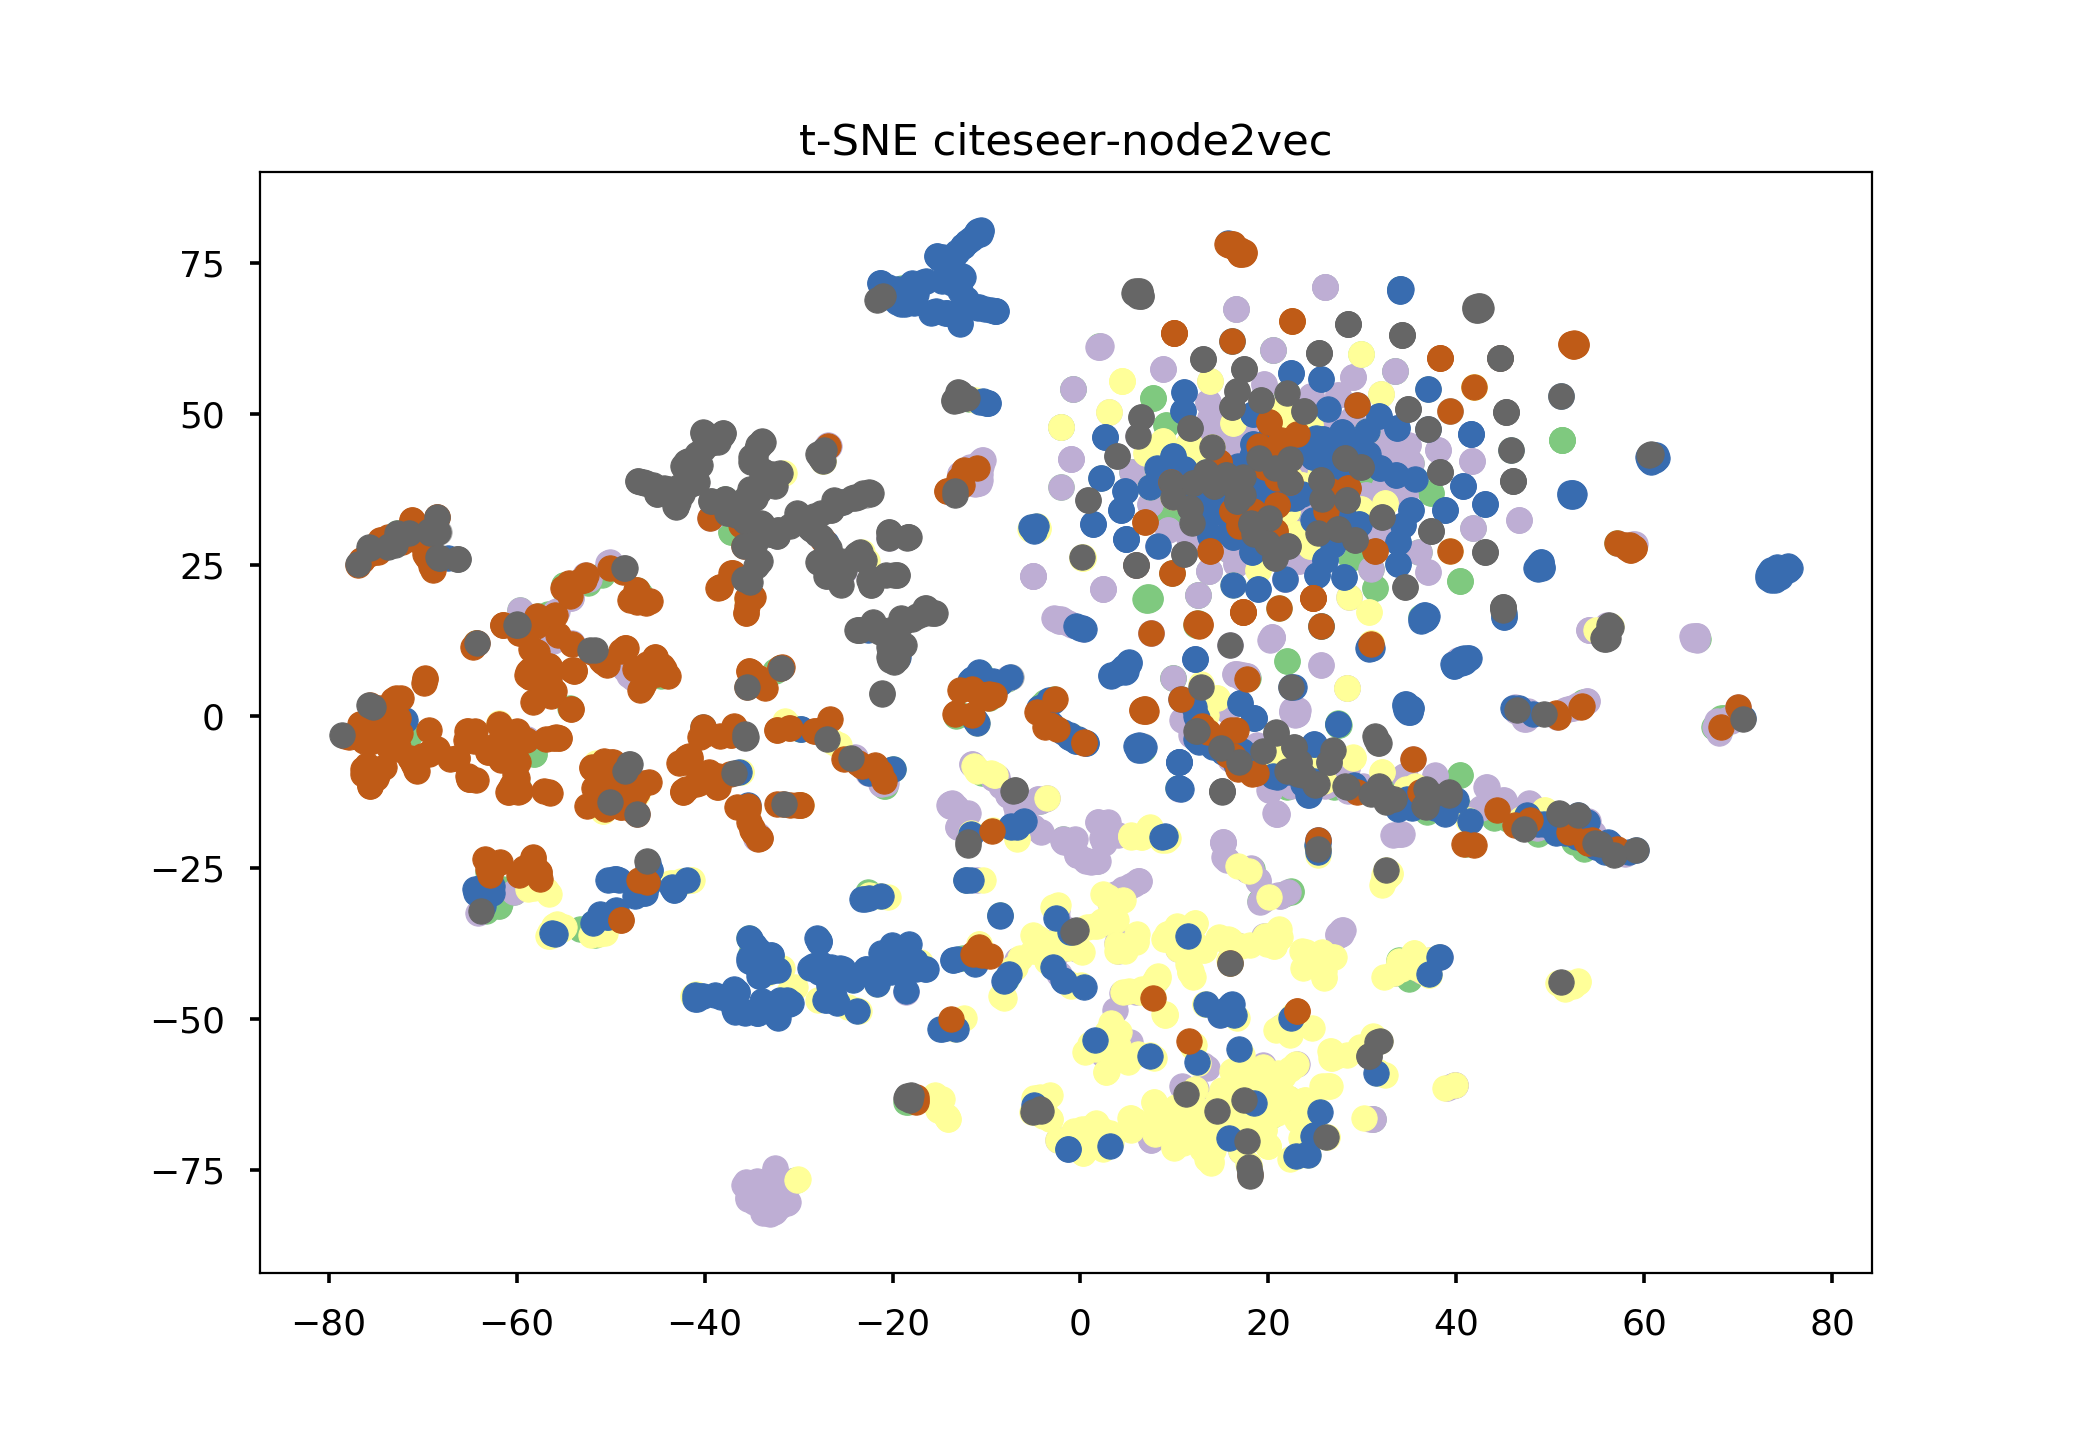

<IPython.core.display.Javascript object>


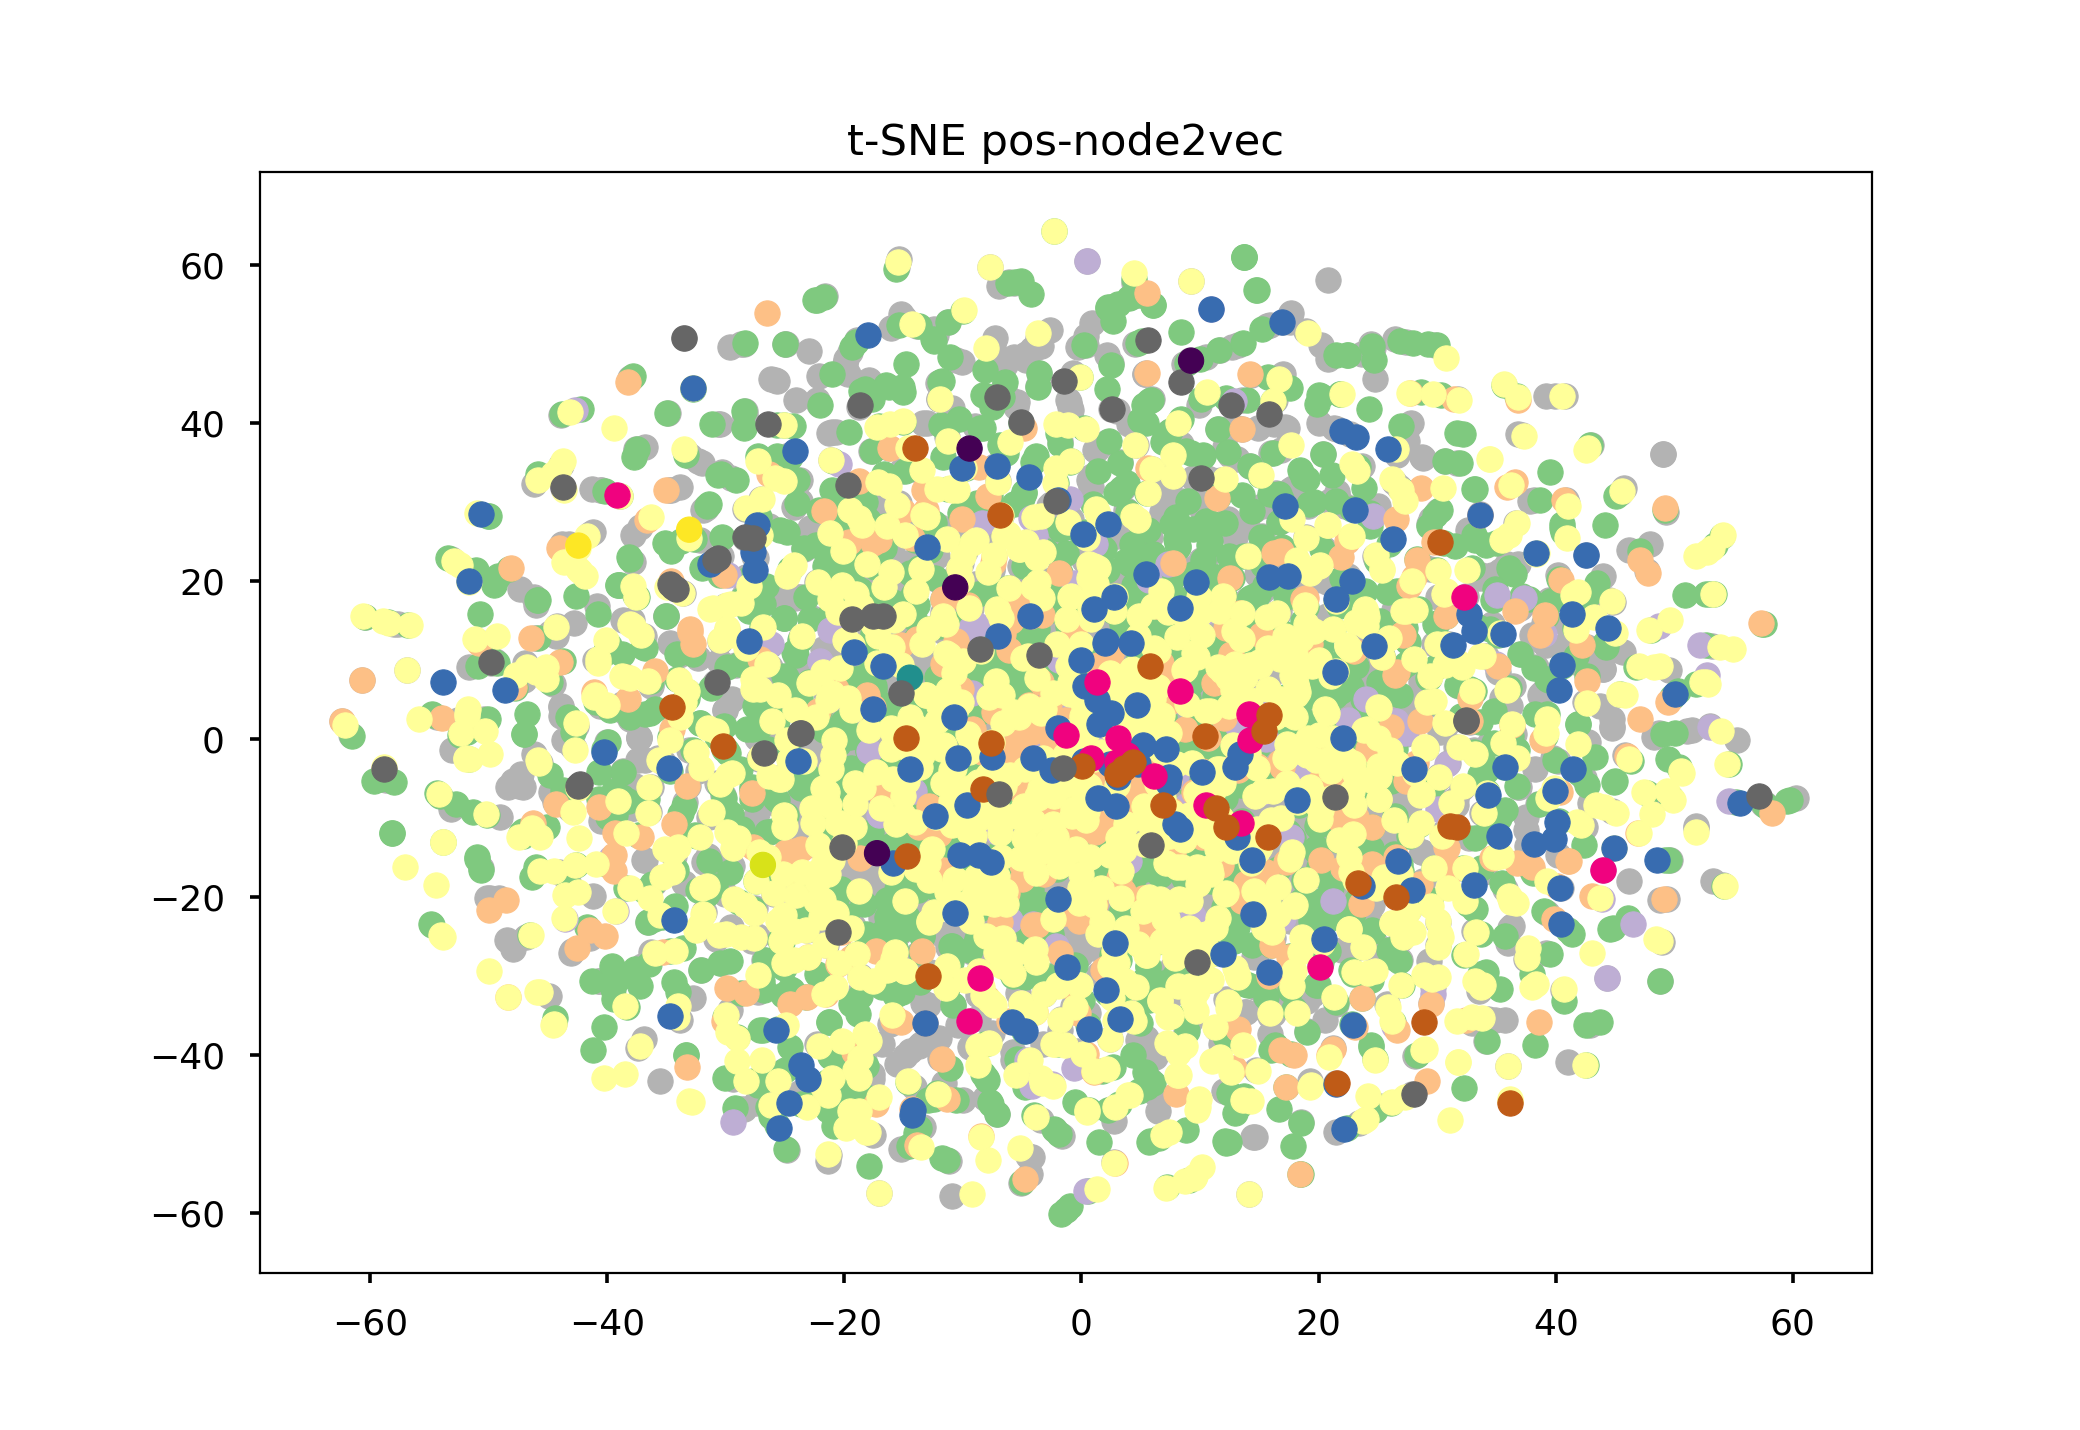

<IPython.core.display.Javascript object>


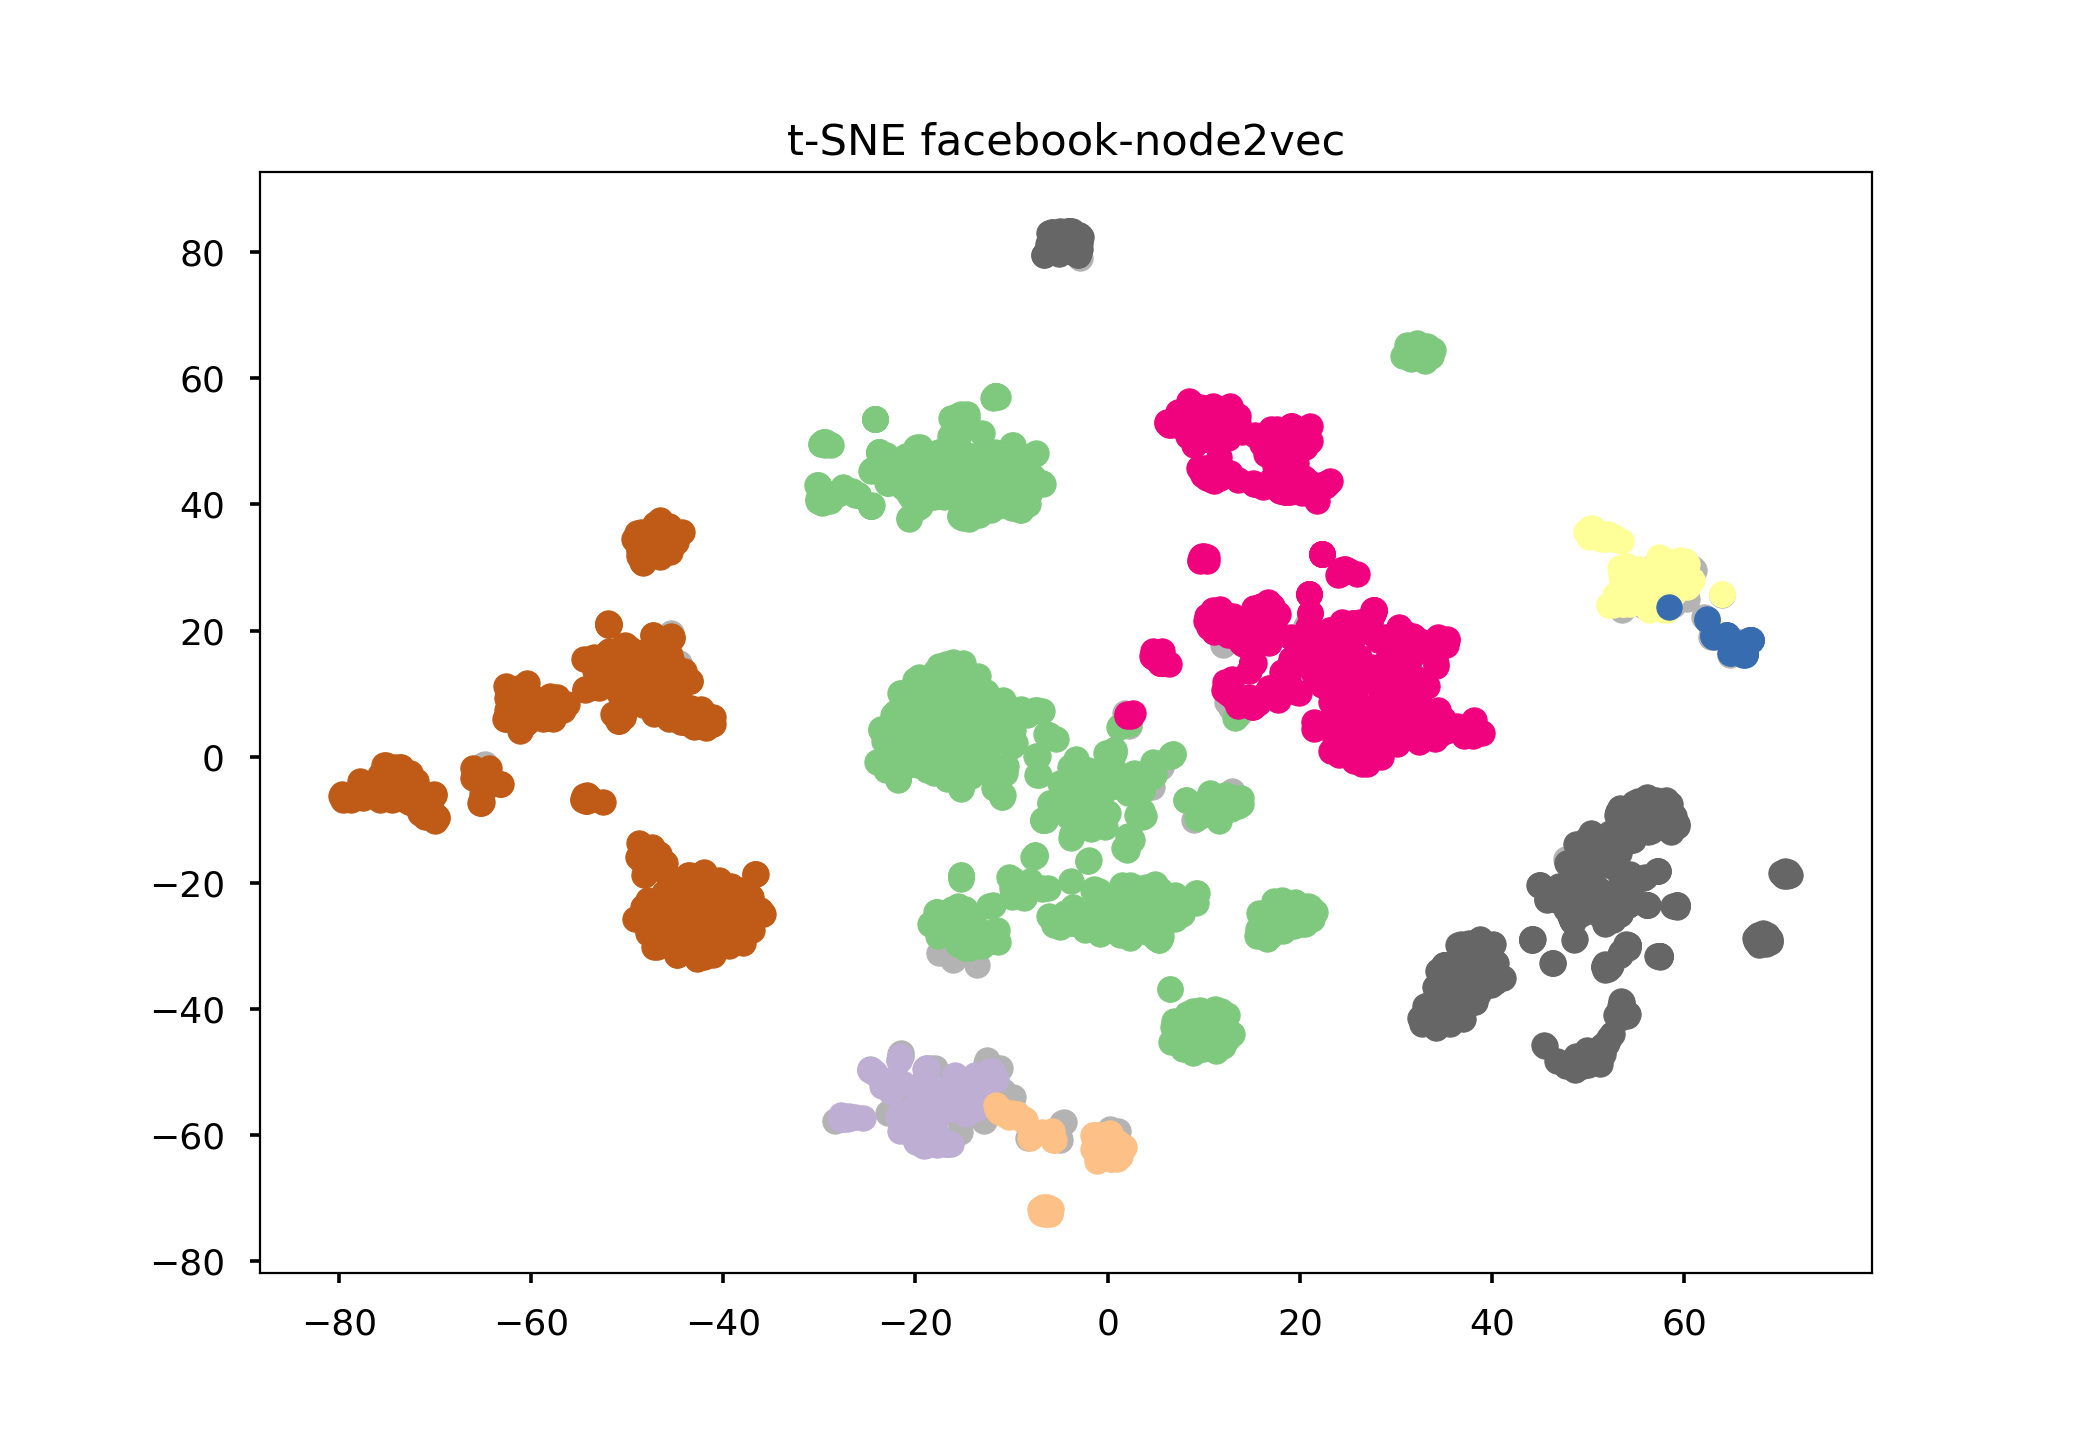

<IPython.core.display.Javascript object>


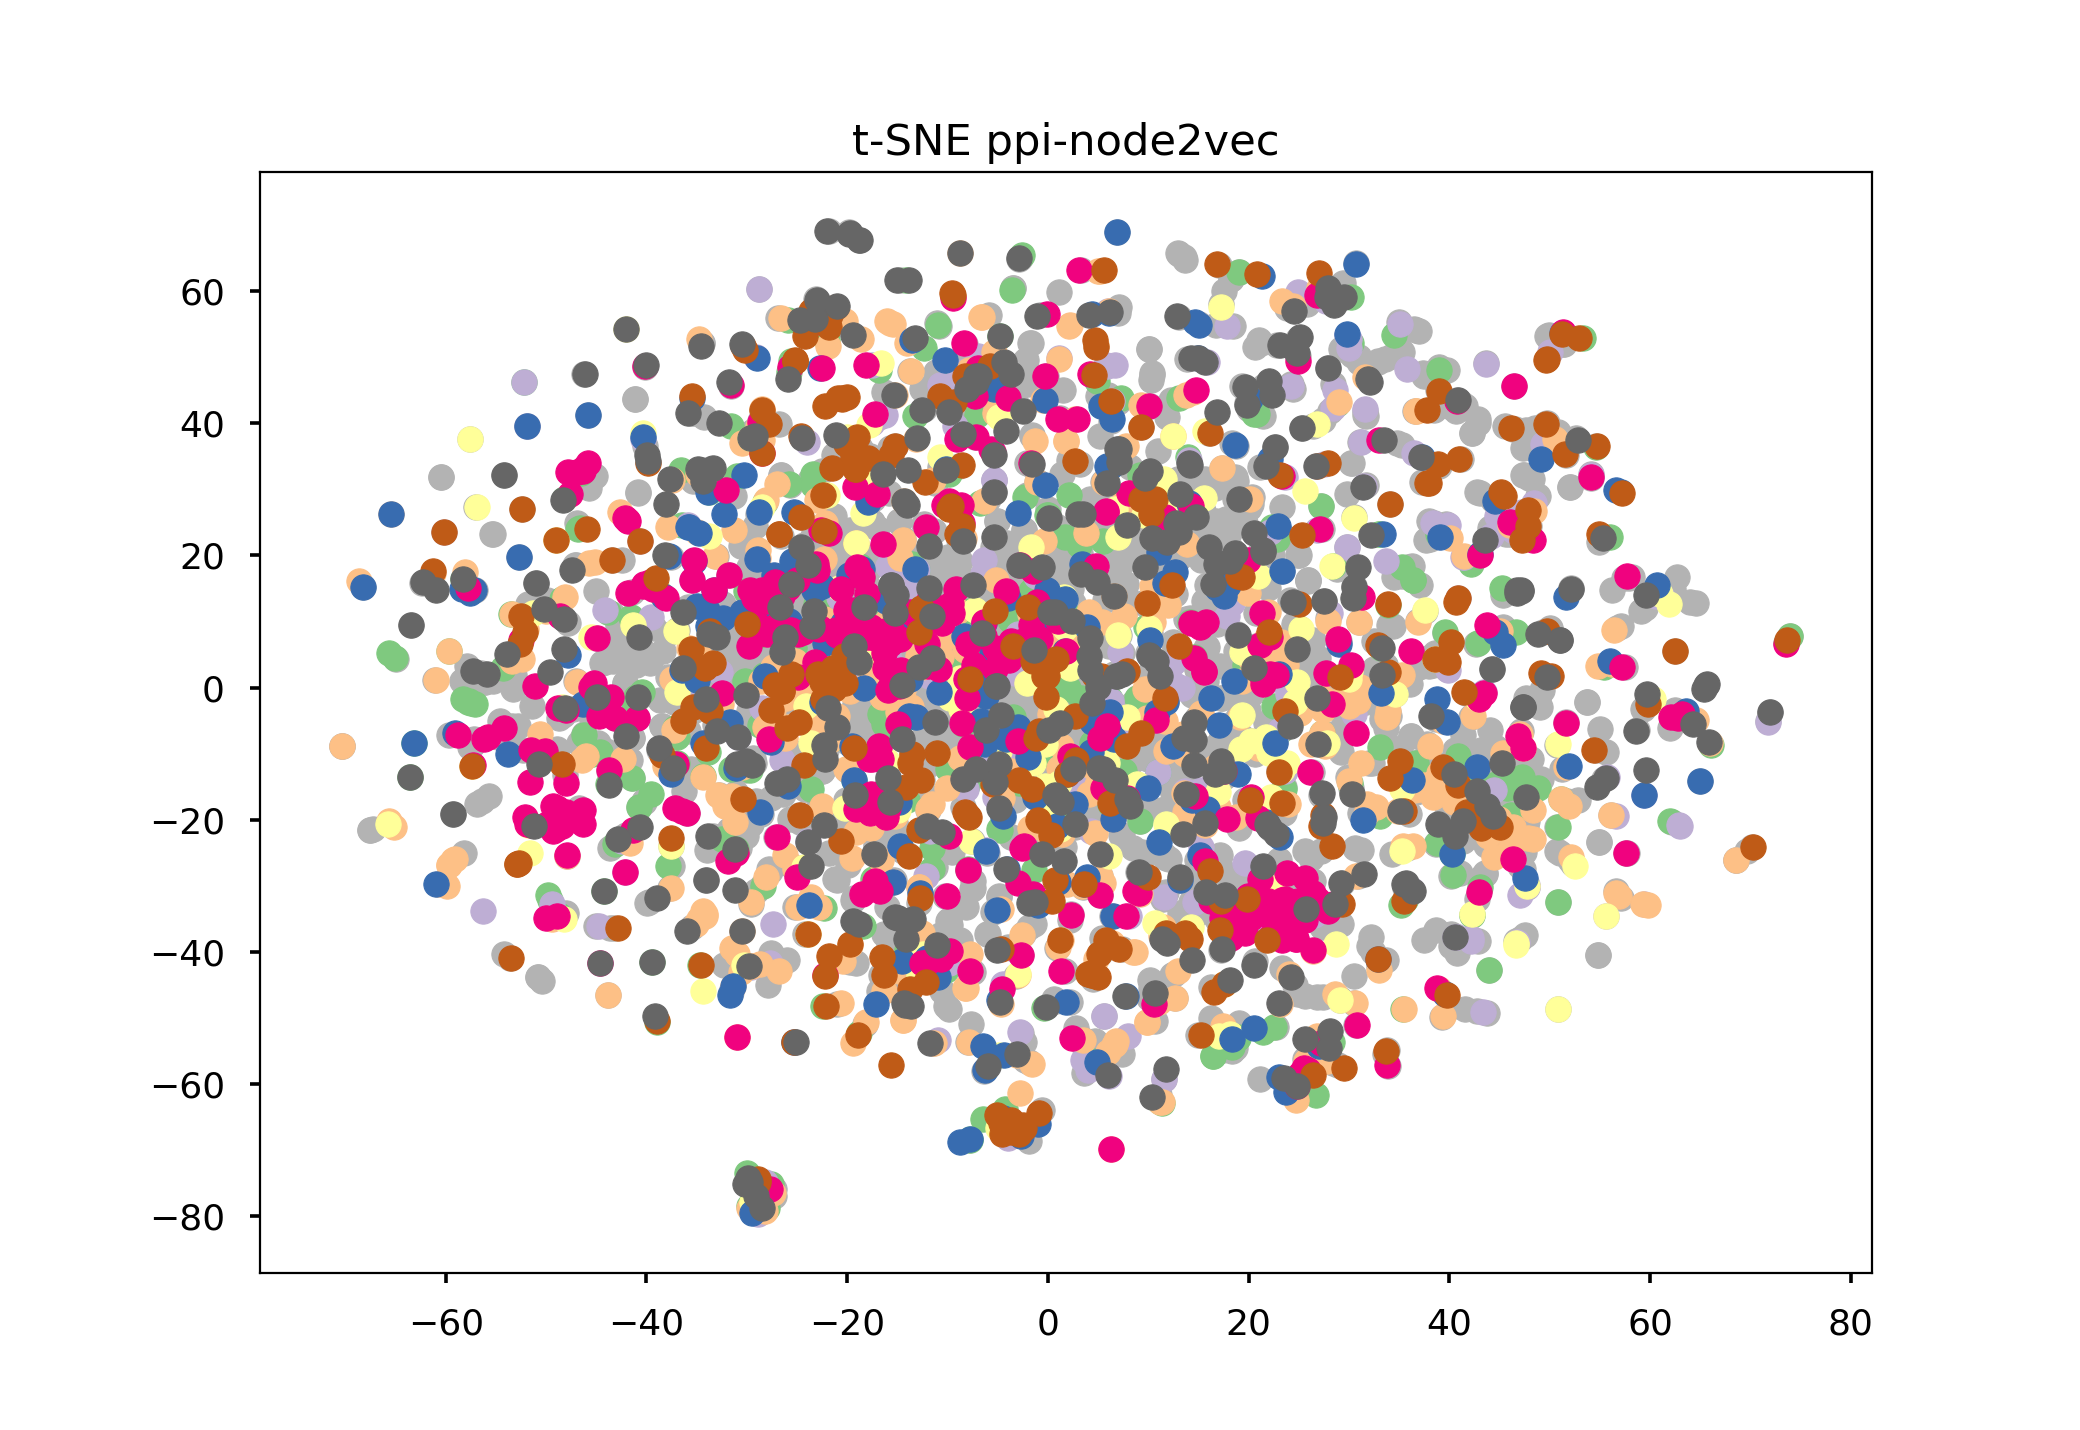

<IPython.core.display.Javascript object>


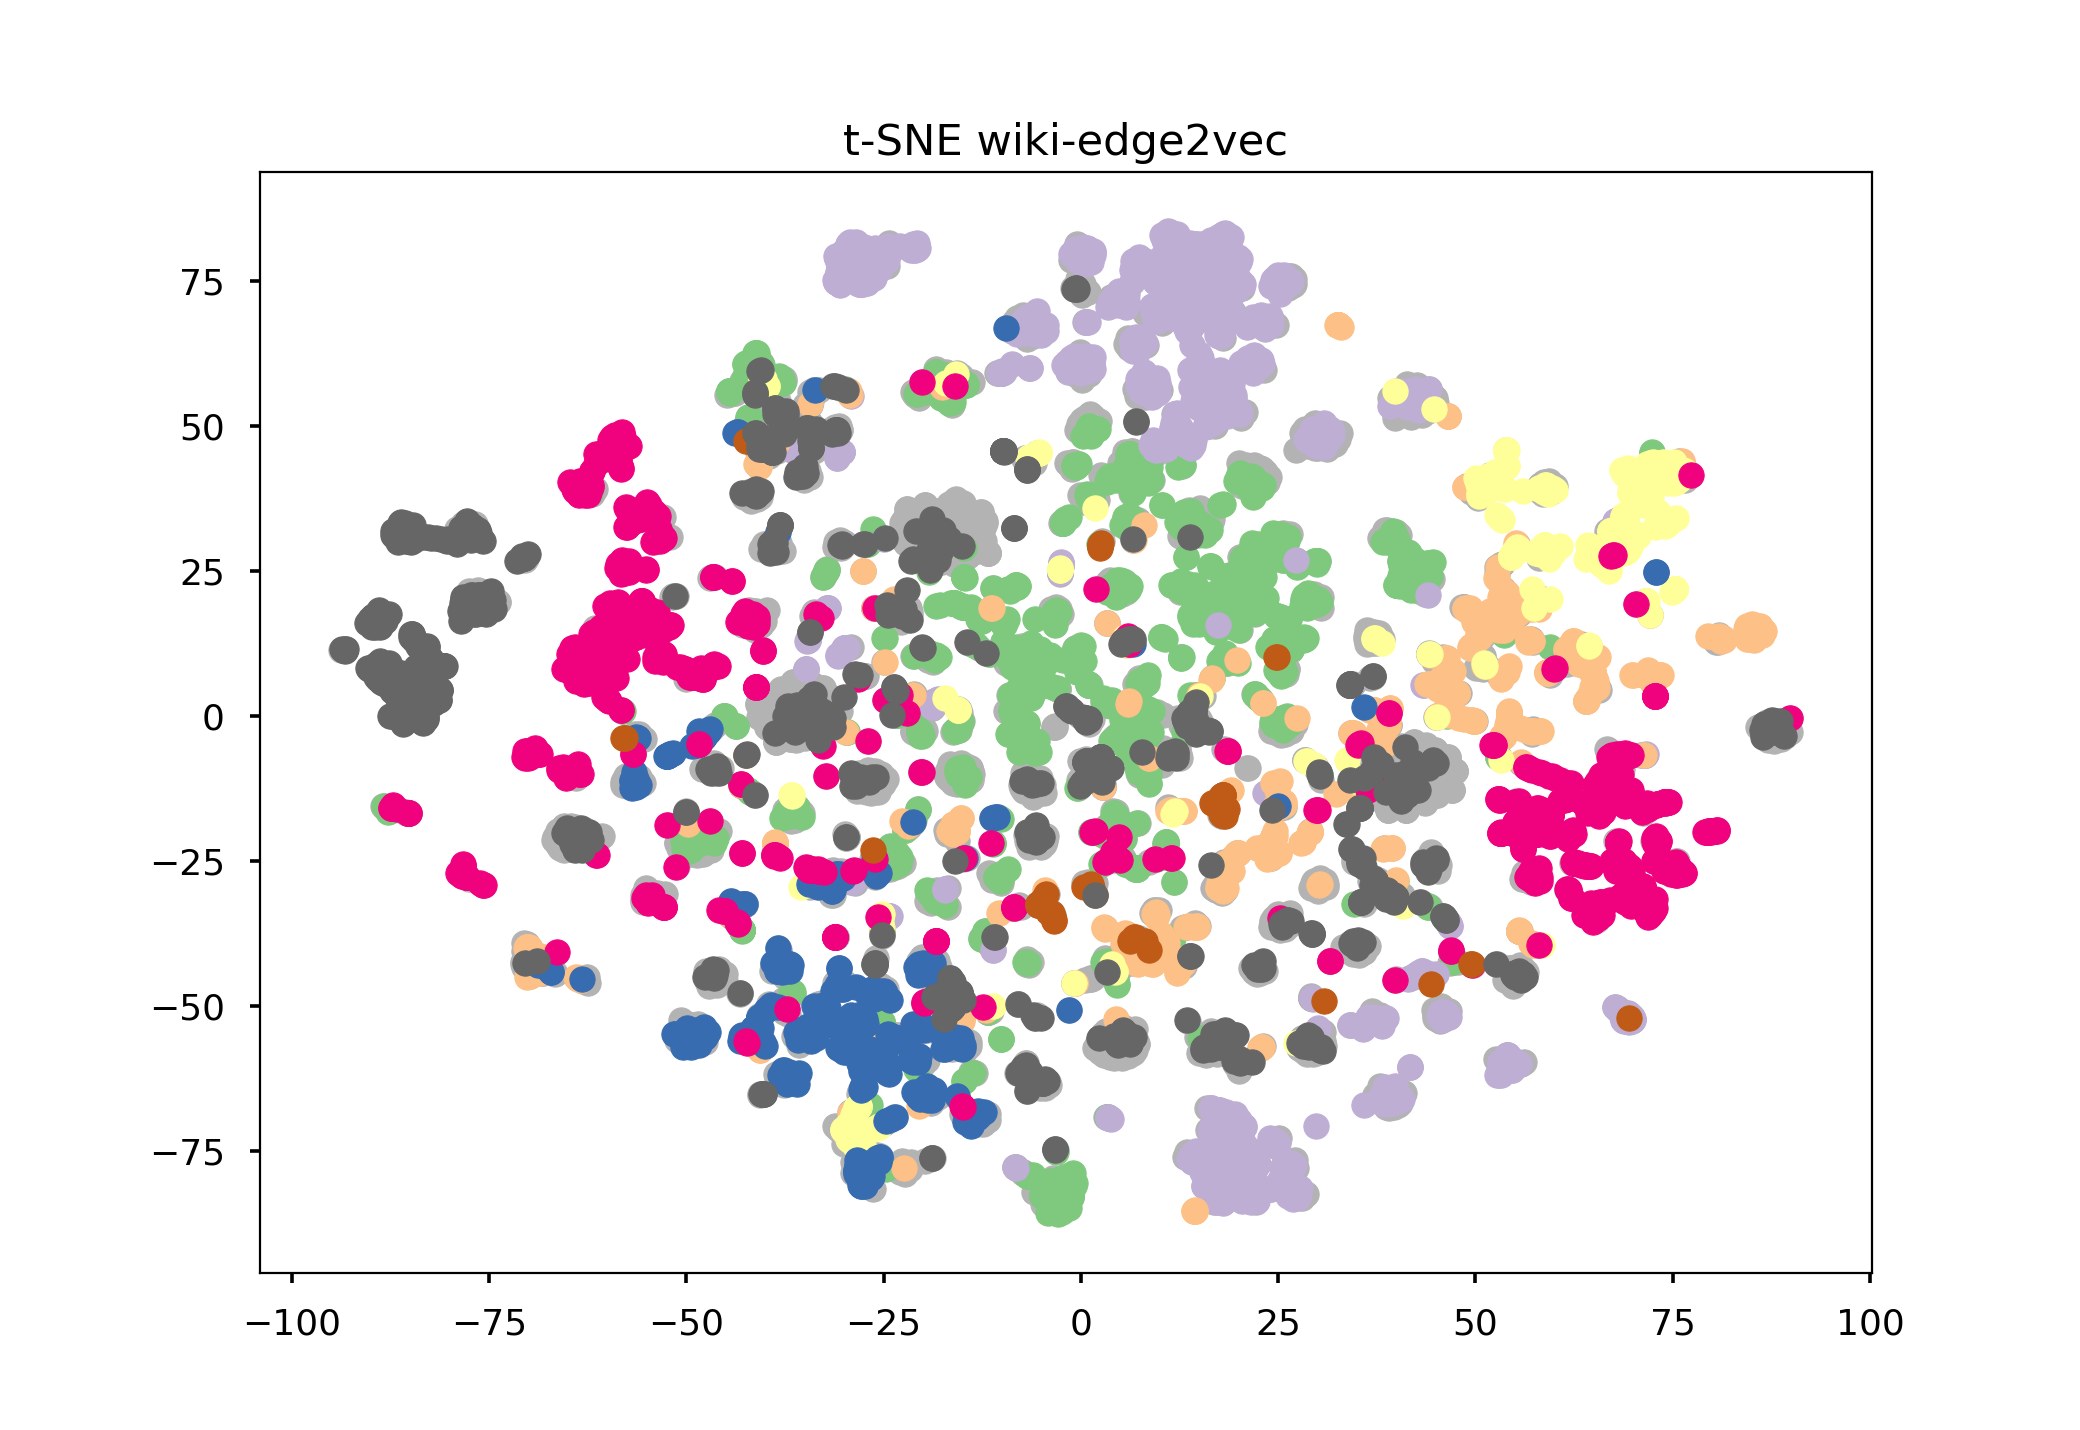

<IPython.core.display.Javascript object>


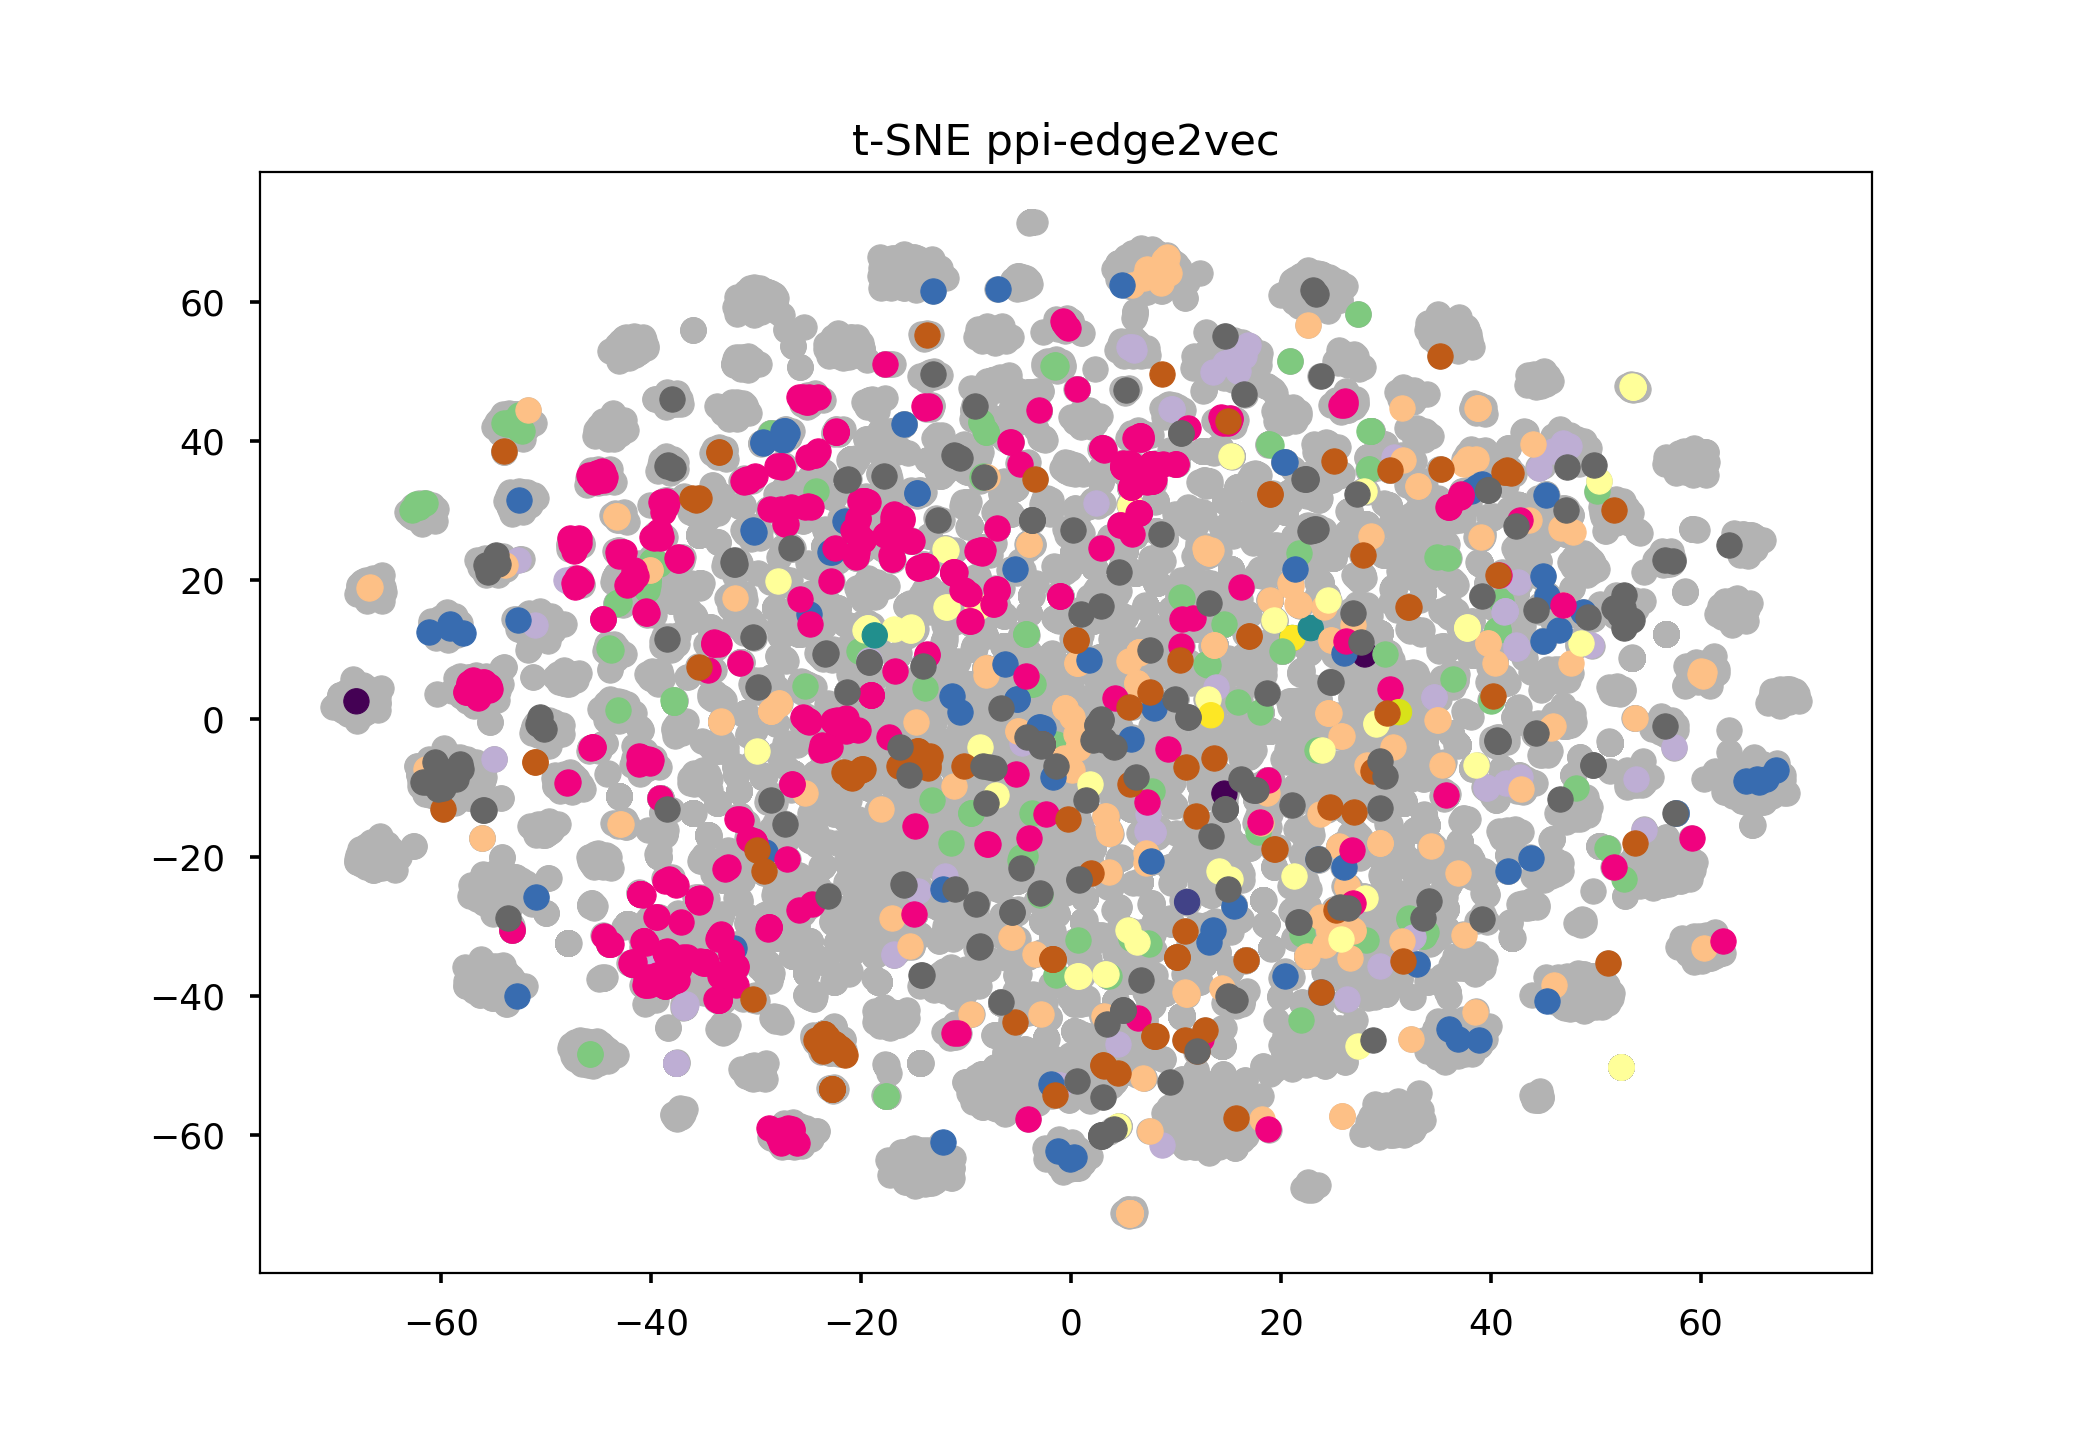

<IPython.core.display.Javascript object>


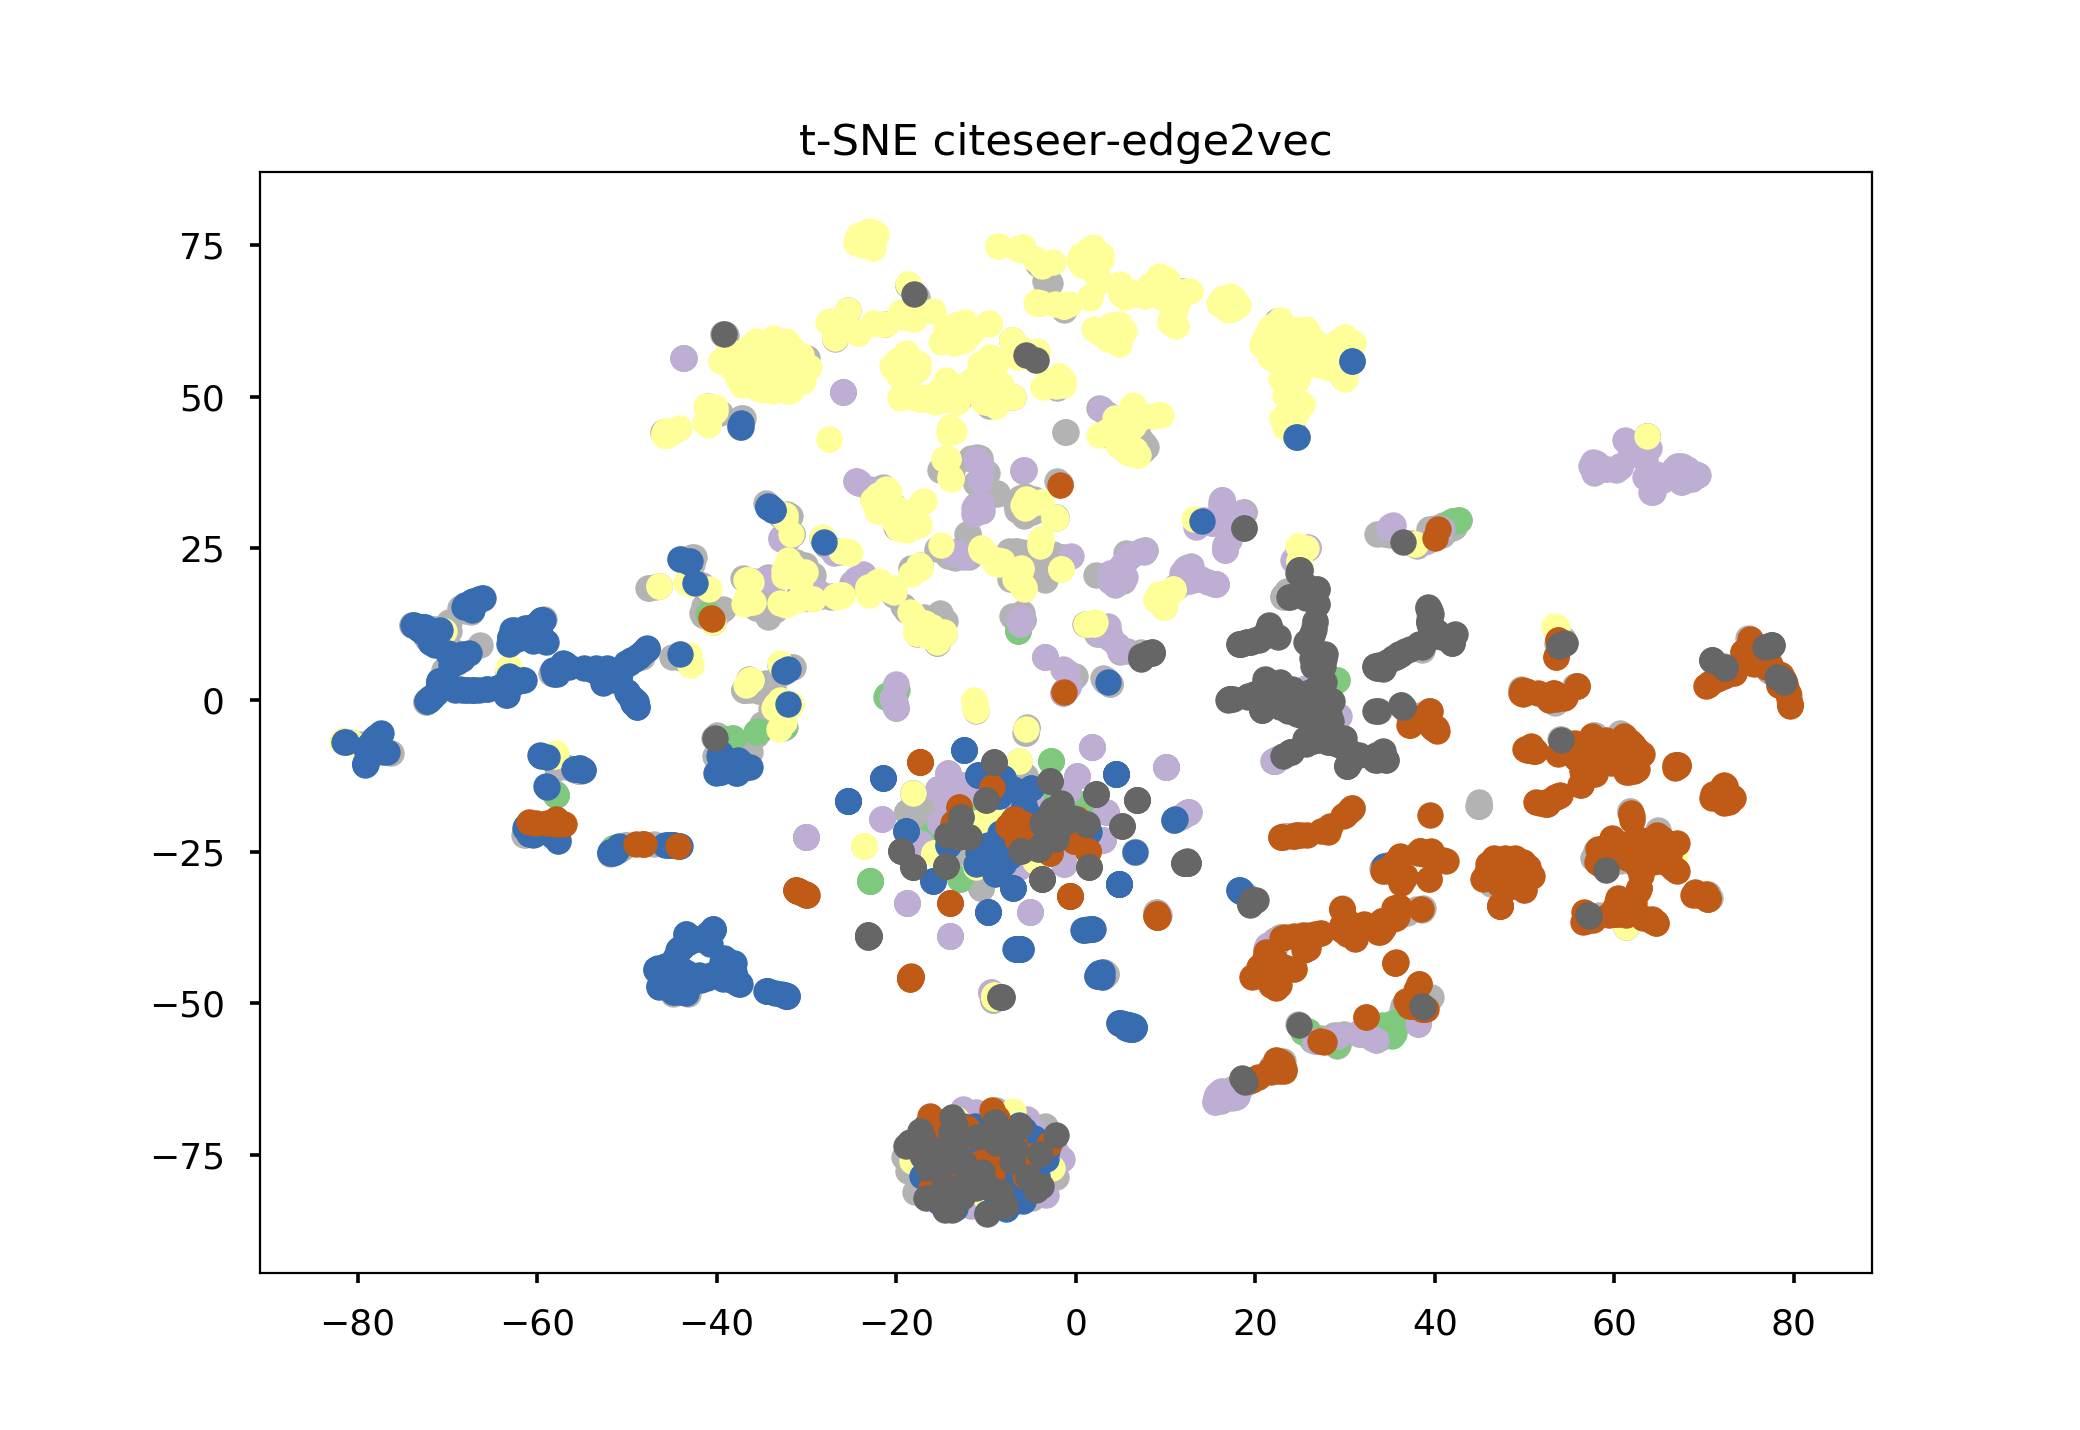

<IPython.core.display.Javascript object>


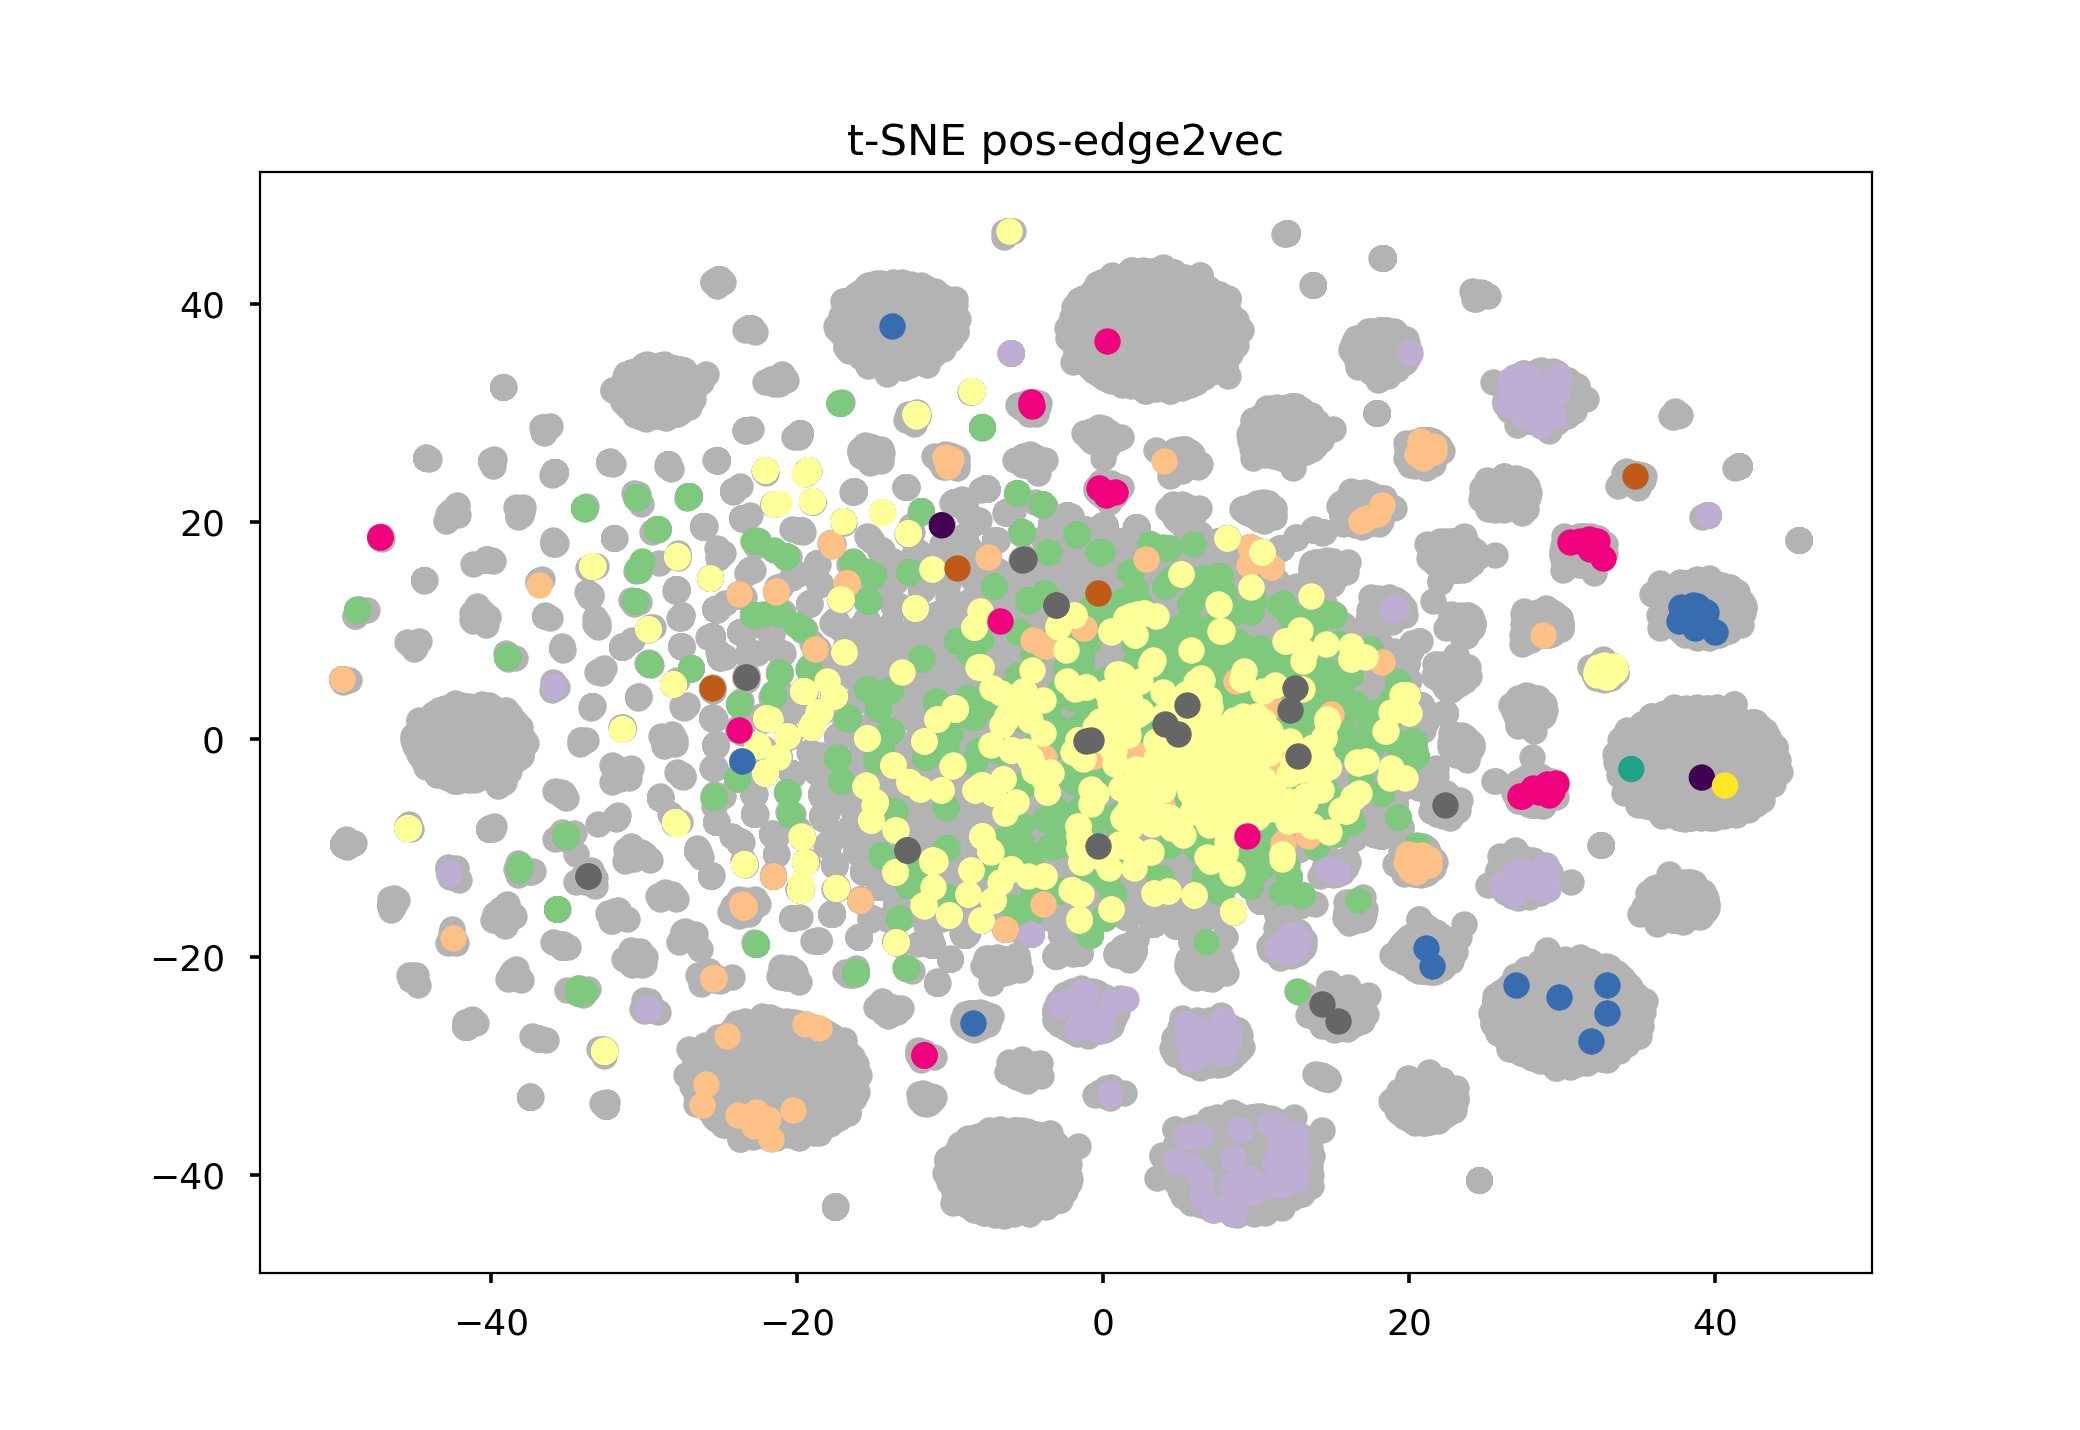

<IPython.core.display.Javascript object>


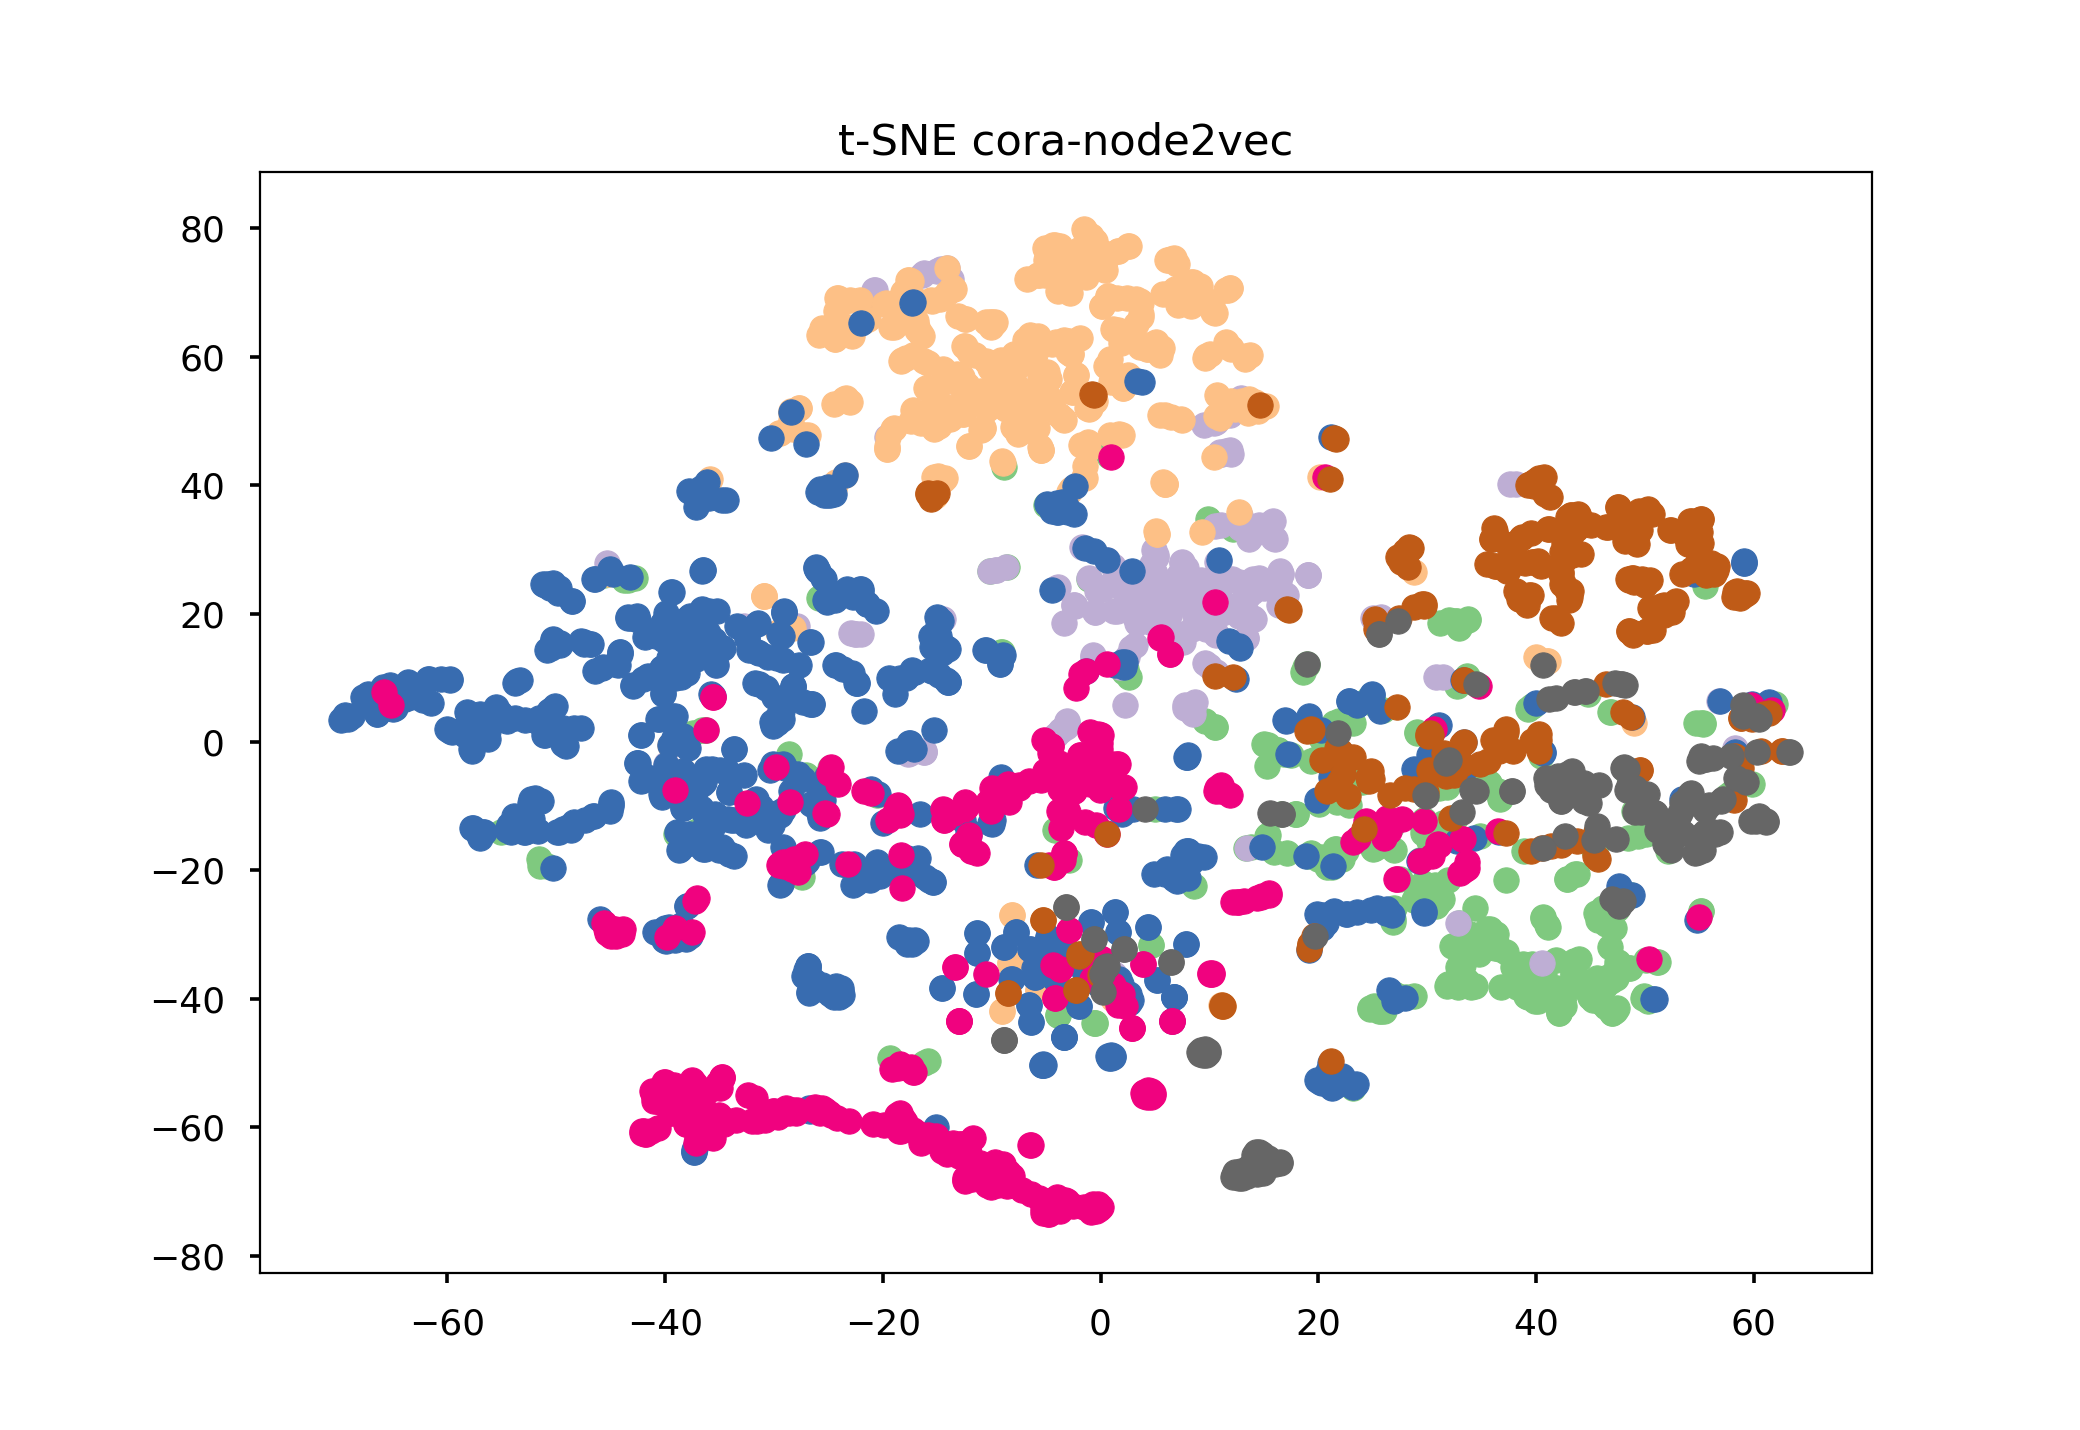

In [9]:
for key in embeddings.keys():
    do_plot(embeddings[key], labels[key], 't-SNE {}'.format(key))

In [ ]:
et('../emb/vec_cora_edge2vec.txt', '../emb/label_cora_edge2vec.txt')

tsne2 = TSNE(n_components=2, random_state=0)
do_plot(tsne2.fit_transform(

## PCA (3D)

In [4]:
do_plot(PCA(n_components=3).fit_transform(X), 'PCA')

NameError: name 'X' is not defined

## t-SNE (3D)

<IPython.core.display.Javascript object>


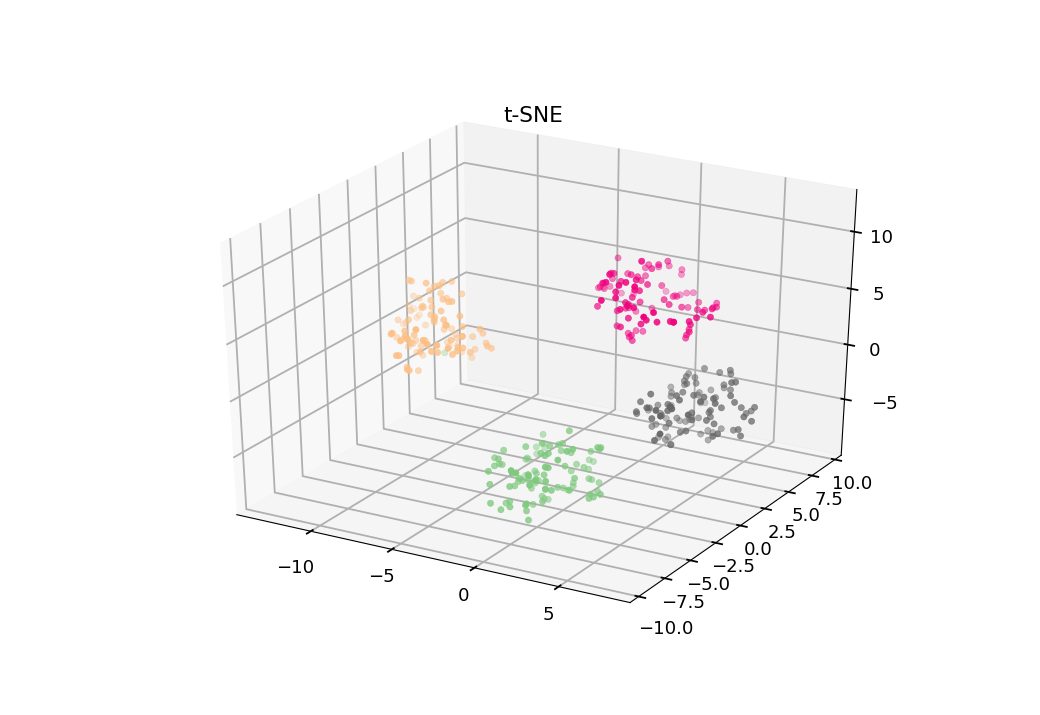

In [11]:
tsne3 = TSNE(n_components=3, learning_rate=100, random_state=0)
do_plot(tsne3.fit_transform(X), y, 't-SNE')

## HDBScan
HDBScan is a fairly recent and well-regarded clustering algorithm. The reason it's here is to see how well it does on some fairly simple data and visualize its results via t-SNE.

Number of clusters: 4


<IPython.core.display.Javascript object>


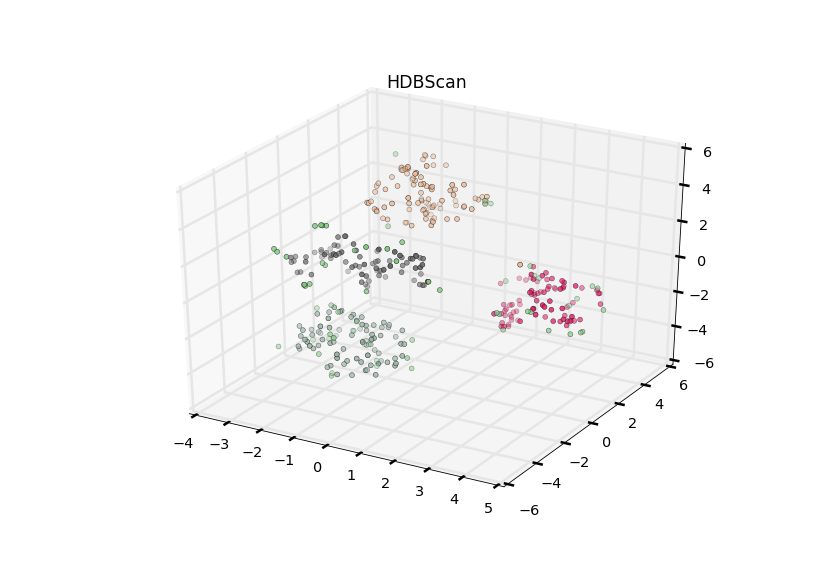

In [97]:
if hdbscan_available:
    clusterer = hdbscan.HDBSCAN(min_cluster_size=20)
    cluster_labels = clusterer.fit_predict(X_std) + 1
    print('Number of clusters: {}'.format(max(cluster_labels)))
    do_plot(tsne3.fit_transform(X), 'HDBScan', labels=cluster_labels)

In [93]:
results= {
'citeseer': {'nodes': 0, 'edges': 4676,
	'node2vec': {'time': 31.0004179478, 'scores': [
	{'micro': 0.5216959258032461, 'weighted': 0.5152212470382227, 'samples': 0.5258764607679466, 'macro': 0.4824423729089012},
	{'micro': 0.5506329113924051, 'weighted': 0.5450973025485346, 'samples': 0.5555972952667168, 'macro': 0.5037971847500834},
	{'micro': 0.5618359541011475, 'weighted': 0.5537832684030708, 'samples': 0.5676255903821382, 'macro': 0.5116521829745435},
	{'micro': 0.5707196029776674, 'weighted': 0.5629300278069077, 'samples': 0.5758637956935403, 'macro': 0.5205354481249848},
	{'micro': 0.5910714285714286, 'weighted': 0.5823815052296963, 'samples': 0.5967548076923077, 'macro': 0.5444902235735865},
	{'micro': 0.5864884929472903, 'weighted': 0.5767114339067664, 'samples': 0.5935386927122465, 'macro': 0.5400336416051038},
	{'micro': 0.5727002967359051, 'weighted': 0.5609746983168363, 'samples': 0.5795795795795796, 'macro': 0.5315224348694126},
	{'micro': 0.5801186943620179, 'weighted': 0.5694832033174068, 'samples': 0.5870870870870871, 'macro': 0.5298251439954147},
	{'micro': 0.5885885885885885, 'weighted': 0.5740268577321699, 'samples': 0.5885885885885885, 'macro': 0.539385909397774}]},
	'edge2vec': {'time': 54.5634970665, 'scores': [
	{'micro': 0.7116005316119233, 'weighted': 0.7062451536316536, 'samples': 0.7334283677833214, 'macro': 0.6625629551564886},
	{'micro': 0.7369319394068702, 'weighted': 0.7305921828511434, 'samples': 0.7588879978615344, 'macro': 0.6945191365778166},
	{'micro': 0.7457916565015857, 'weighted': 0.7398736737139663, 'samples': 0.7658827122785583, 'macro': 0.7074645127758158},
	{'micro': 0.759417808219178, 'weighted': 0.7545813037488058, 'samples': 0.7790449037776194, 'macro': 0.7240650573284692},
	{'micro': 0.7686261107313738, 'weighted': 0.7647948033530594, 'samples': 0.789349871685201, 'macro': 0.7309303628070171},
	{'micro': 0.7694278394534586, 'weighted': 0.7646216358202682, 'samples': 0.7942276857295564, 'macro': 0.7322432961217612},
	{'micro': 0.776, 'weighted': 0.7709550897062851, 'samples': 0.8032786885245902, 'macro': 0.7355966429243012},
	{'micro': 0.7632933104631218, 'weighted': 0.7577445741342378, 'samples': 0.7922008547008547, 'macro': 0.723226216206123},
	{'micro': 0.7698961937716263, 'weighted': 0.761605045239244, 'samples': 0.7948717948717948, 'macro': 0.7218833819872167}]}
},
'cora':  {'nodes': 0, 'edges': 5278,
	'node2vec': {'time': 30.1572370529, 'scores': [
	{'micro': 0.7514356029532404, 'weighted': 0.7496842952538284, 'samples': 0.7514356029532404, 'macro': 0.7369471052170172},
	{'micro': 0.7803414859252422, 'weighted': 0.7789765783461711, 'samples': 0.7803414859252422, 'macro': 0.768195238897702},
	{'micro': 0.793776371308017, 'weighted': 0.7926836564864591, 'samples': 0.7937763713080169, 'macro': 0.7863040324821956},
	{'micro': 0.8055384615384615, 'weighted': 0.8045709693811632, 'samples': 0.8055384615384615, 'macro': 0.7997633051671066},
	{'micro': 0.808714918759232, 'weighted': 0.8083162955367285, 'samples': 0.808714918759232, 'macro': 0.7987819858539389},
	{'micro': 0.8136531365313654, 'weighted': 0.8126726084634159, 'samples': 0.8136531365313653, 'macro': 0.8088770326951903},
	{'micro': 0.8216482164821647, 'weighted': 0.8207802942916989, 'samples': 0.8216482164821648, 'macro': 0.812821381804965},
	{'micro': 0.8136531365313654, 'weighted': 0.8134252472626994, 'samples': 0.8136531365313653, 'macro': 0.8028182810846091},
	{'micro': 0.8118081180811808, 'weighted': 0.8112556578400962, 'samples': 0.8118081180811808, 'macro': 0.7905356240010308}]},
	'edge2vec': {'time': 78.8309521675, 'scores': [
	{'micro': 0.8684490084985835, 'weighted': 0.8678431327187914, 'samples': 0.8874973689749527, 'macro': 0.8596779722713112},
	{'micro': 0.8890662410215483, 'weighted': 0.8889530844496101, 'samples': 0.9072933933222828, 'macro': 0.883177945022395},
	{'micro': 0.8955905871601554, 'weighted': 0.895569844023302, 'samples': 0.915426251691475, 'macro': 0.8899905260299372},
	{'micro': 0.8974427277570591, 'weighted': 0.8973343728281169, 'samples': 0.9169561098831702, 'macro': 0.8936708681296318},
	{'micro': 0.9035565523870555, 'weighted': 0.903452448881104, 'samples': 0.9217506631299734, 'macro': 0.8988633841696428},
	{'micro': 0.9047619047619048, 'weighted': 0.9045878044597411, 'samples': 0.9223484848484849, 'macro': 0.8999637212523214},
	{'micro': 0.9109333333333334, 'weighted': 0.910754806010765, 'samples': 0.9286616161616161, 'macro': 0.9061966232842895},
	{'micro': 0.9129392971246006, 'weighted': 0.9131331264202265, 'samples': 0.9308712121212122, 'macro': 0.9117299098410486},
	{'micro': 0.9092356687898089, 'weighted': 0.9093370891482615, 'samples': 0.9318181818181818, 'macro': 0.903641523542243}]}
}
}

In [95]:
print(results['citeseer']['node2vec']['scores'][0]['micro'])

0.521695925803
